## 14.1 텐서플로의 주요 특징

## 14.2 텐서플로의 계산 그래프: 텐서플로 v2로 이전

* 즉시 실행, 동적 계산 그래프

### 14.2.6 함수 데코레이터로 계산 성능 높이기

`@tf.function`: 정적 타입과 크기가 필요하지만 이를 동적 타이핑으로 처리할 수 있음

## 14.3 모델 파라미터를 저장하고 업데이트하기 위한 텐서플로 변수 객체

In [1]:
# 랜덤 초기화의 일종 고전적인 랜덤 초기화 방법: 글로럿 초기화 (GlorotNormal)

import tensorflow as tf

tf.random.set_seed(1)
init = tf.keras.initializers.GlorotNormal()
tf.print(init(shape=(3, )))

[-0.722795904 1.01456821 0.251808226]


2022-04-26 09:58:26.331389: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
v = tf.Variable(init(shape=(2, 3)))
tf.print(v)

[[0.28982234 -0.782292783 -0.0453658961]
 [0.960991383 -0.120003454 0.708528221]]


In [3]:
class MyModule(tf.Module):
    def __init__(self):
        init = tf.keras.initializers.GlorotNormal()
        self.w1 = tf.Variable(init(shape=(2, 3)),
                              trainable=True)
        self.w2 = tf.Variable(init(shape=(1, 2)),
                              trainable=False)

m = MyModule()
print('모든 변수: ', [v.shape for v in m.variables])
print('훈련 가능한 변수: ', [v.shape for v in m.trainable_variables])

모든 변수:  [TensorShape([2, 3]), TensorShape([1, 2])]
훈련 가능한 변수:  [TensorShape([2, 3])]


2022-04-26 09:58:26.595055: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [4]:
# 함수 밖에서 Variable 객체를 정의하고 데코레이터 사용
w = tf.Variable(tf.random.uniform((3, 3)))

@tf.function
def compute_z(x):
    return tf.matmul(w, x)

x = tf.constant([[1], [2], [3]], dtype=tf.float32)
tf.print(compute_z(x))

[[1.20935762]
 [3.89828062]
 [1.65398622]]


2022-04-26 09:58:26.734241: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


## 14.4 자동 미분과 GradientTape로 그레디언트 계산

### 14.4.1 훈련 가능한 변수에 대한 손실의 그레디언트 계산

$z\,=\,wx\,+\,b$을 자동 미분하여 제곱 오차 - loss를 구하고 이를 $w$에 대해 편미분해서 그레디언트 구하기

In [5]:
w = tf.Variable(1.0)
b = tf.Variable(0.5)
print(w.trainable, b.trainable)

True True


In [6]:
x = tf.convert_to_tensor([1.4])
y = tf.convert_to_tensor([2.1])
with tf.GradientTape() as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))
dloss_dw = tape.gradient(loss, w)
tf.print('dL/dw: ', dloss_dw)

dL/dw:  -0.559999764


### 14.4.2 훈련하지 않는 변수에 대한 그레디언트 계산
`tf.watch()`: 적대 샘플을 생성하는 데 사용

### 14.4.3 여러 개의 그레디언트 계산

`tf.GradientTape(persistent=True)`

In [7]:
with tf.GradientTape(persistent=True) as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))
dloss_dw = tape.gradient(loss, w)
tf.print('dL/dw: ', dloss_dw)

dloss_db = tape.gradient(loss, b)
tf.print('dL/db: ', dloss_db)

dL/dw:  -0.559999764
dL/db:  -0.399999857


In [8]:
# keras API 이용하여 구하기
optimizer = tf.keras.optimizers.SGD()
optimizer.apply_gradients(zip([dloss_dw, dloss_db], [w, b]))
tf.print('업데이트 된 w: ', w)
tf.print('업데이트 된 b: ', b)

업데이트 된 w:  1.0056
업데이트 된 b:  0.504


## 14.5 케라스 API를 사용하여 일반적인 구조 구현하기  

* 공식 문서 링크

* 각 layer에 적용 가능

`tf.keras.activations`: http://www.tensorflow.org/api_docs/python/tf/keras/activations  
`tf.keras.initializers`: http://www.tensorflow.org/api_docs/python/tf/keras/initializers  
`tf.keras.regularizers`: http://www.tensorflow.org/api_docs/python/tf/keras/regularizers  

* compile할 때 모델의 설정 바꾸기

`tf.keras.optimizers`: http://www.tensorflow.org/api_docs/python/tf/keras/optimizers  
`tf.keras.losses`: http://www.tensorflow.org/api_docs/python/tf/keras/losses  
`tf.kera.metrics`: http://www.tensorflow.org/api_docs/python/tf/keras/metrics

In [9]:
# 복습
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))

model.build(input_shape=(None, 4))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________


In [10]:
# 훈련하는 / 훈련하지 않는 파라미터 출력하기
for v in model.variables:
    print('{:20s}'.format(v.name), v.trainable, v.shape)

dense/kernel:0       True (4, 16)
dense/bias:0         True (16,)
dense_1/kernel:0     True (16, 32)
dense_1/bias:0       True (32,)


### 14.5.1 XOR 분류 문제 풀어 보기

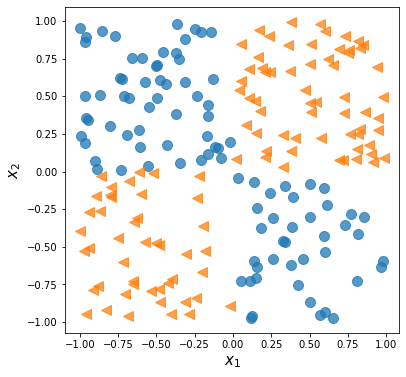

In [11]:
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(1)
np.random.seed(1)

x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1] < 0] = 0

x_train = x[:100, :]
y_train = y[:100]

x_valid = x[100:, :]
y_valid = y[100:]

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0],
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0],
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

In [12]:
# 간단한 기본 모델로 시작
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1,
                                input_shape=(2, ),
                                activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [13]:
# 컴파일 그리고 적합
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

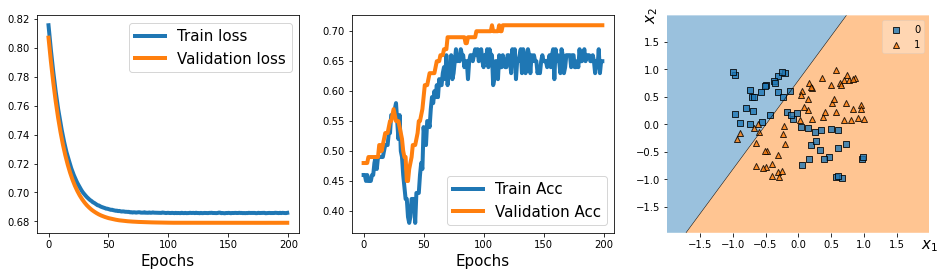

In [14]:
# 결정 영역과 훈련 성능을 그리기
from mlxtend.plotting import plot_decision_regions
history = hist.history
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc', 'Validation Acc'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.int64), clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

# 은닉층이 없는 단순한 모델은 선형 결정 경계만 찾게 되어 결과가 좋지 않다.

In [15]:
# 은닉층을 1~4개까지 더해보기
tf.random.set_seed(1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=(2, ),
                                activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 컴파일
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# 훈련
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

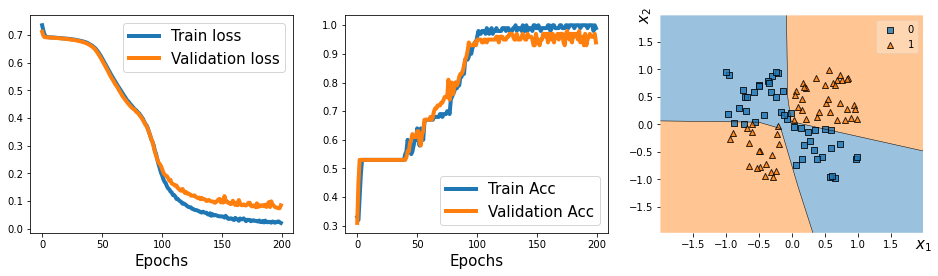

In [17]:
# 그림 그리기 (이전 코드 재사용)
history = hist.history
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc', 'Validation Acc'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.int64), clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

### 14.5.3 케라스의 Model 클래스 기반으로 모델 만들기

In [18]:
# tf.keras.Model 상속한 새로운 클래스 생성
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = tf.keras.layers.Dense(
            units=4, activation='relu')
        self.hidden_2 = tf.keras.layers.Dense(
            units=4, activation='relu')
        self.hidden_3 = tf.keras.layers.Dense(
            units=4, activation='relu')
        self.output_layer = tf.keras.layers.Dense(
            units=1, activation='sigmoid')
        
    def call(self, inputs):
        h = self.hidden_1(inputs)
        h = self.hidden_2(h)
        h = self.hidden_3(h)
        return self.output_layer(h)

In [19]:
tf.random.set_seed(1)
model = MyModel()  # 일반적인 모델 속성을 상속
model.build(input_shape=(None, 2))
model.summary()

# Compile
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Training
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              multiple                  12        
_________________________________________________________________
dense_8 (Dense)              multiple                  20        
_________________________________________________________________
dense_9 (Dense)              multiple                  20        
_________________________________________________________________
dense_10 (Dense)             multiple                  5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [20]:
# train_step() method에서 tf.GradientTape 컨텍스트로 훈련 단계를 세밀하게 조정할 수 있다.
class MyCustomStepModel (MyModel):
    
    def train_step(self, data):
        # fit()에 전달된 데이터
        x, y = data
        
        # gradient 기록 시작
        with tf.GradientTape() as tape:
            # 정방향 계산
            y_pred = self(x)
            # compile() method에서 지정한 손실 계산
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            
        # 훈련 가능한 파라미터에 대한 그레디언트 계산
        gradients = tape.gradient(loss, self.trainable_variables)
        # 파라미터 업데이트
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # TF 2.4에서
        # self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
        
        # compile() 메서드에서 지정한 지표 계산
        self.compiled_metrics.update_state(y, y_pred)
        
        # 현재까지 지표와 결과값을 딕셔너리로 반환
        return {m.name: m.result() for m in self.metrics}

### 14.5.4 사용자 정의 케라스 층 만들기

$w(x\,+\,\epsilon)\,+\,b$ 계산을 수행하는 NoisyLinear 층 만들어 보기

In [21]:
class NoisyLinear(tf.keras.layers.Layer):
    def __init__(self, output_dim, noise_stddev=0.1, **kwargs):
        self.output_dim = output_dim
        self.noise_stddev = noise_stddev
        super(NoisyLinear, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.w = self.add_weight(name='weights',
                                 shape=(input_shape[1],
                                        self.output_dim),
                                 initializer='random_normal',
                                 trainable=True)
        
        self.b = self.add_weight(shape=(self.output_dim, ),
                                 initializer='zeros',
                                 trainable=True)
        
    def call(self, inputs, training=False):
        if training:
            batch = tf.shape(inputs)[0]
            dim = tf.shape(inputs)[1]
            noise = tf.random.normal(shape=(batch, dim),
                                     mean=0.0,
                                     stddev=self.noise_stddev)
            
            noisy_inputs = tf.add(inputs, noise)
        
        else:
            noisy_inputs = inputs
        z = tf.matmul(noisy_inputs, self.w) + self.b
        return tf.keras.activations.relu(z)
    
    def get_config(self):
        config = super(NoisyLinear, self).get_config()
        config.update({'output_dim': self.output_dim,
                       'noise_stddev': self.noise_stddev})
        return config

In [22]:
# 인스턴스 객체를 만들고,
# build() - 초기화,
# 입력 텐서를 전달하여 실행
# get_config() - 직렬화
# from_config() - 직렬화된 객체를 복원

tf.random.set_seed(1)
noisy_layer = NoisyLinear(4)
noisy_layer.build(input_shape=(None, 4))
x = tf.zeros(shape=(1, 4))
tf.print(noisy_layer(x, training=True))

# 설정을 사용하여 모델 만들기
config = noisy_layer.get_config()
new_layer = NoisyLinear.from_config(config)
tf.print(new_layer(x, training=True))

[[0 0.00821428 0 0]]
[[0 0.0108502861 0 0]]


In [23]:
# NoisyLinear 층을 다층 퍼셉트론의 첫 번째 은닉층으로 사용
tf.random.set_seed(1)
model = tf.keras.Sequential([
    NoisyLinear(4, noise_stddev=0.1),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model.build(input_shape=(None, 2))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noisy_linear_1 (NoisyLinear) (None, 4)                 12        
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 컴파일
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [25]:
# 훈련
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2,
                 verbose=0)

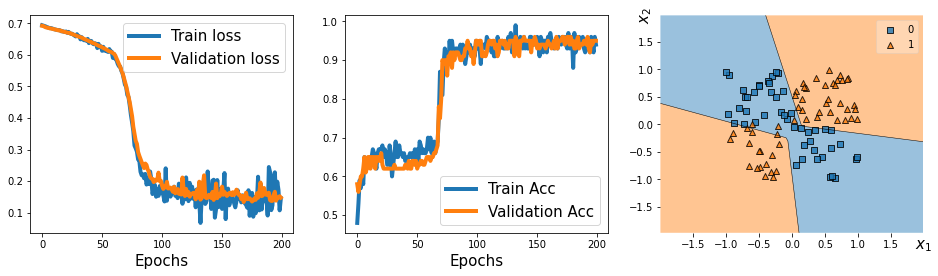

In [26]:
# 그림 그리기 (이전 코드 재사용)
history = hist.history
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc', 'Validation Acc'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.int64), clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

## 14.6 텐서플로 추정기

In [27]:
import pandas as pd
dataset_path = tf.keras.utils.get_file(
    "auto-mpg.data",
    ("http://archive.ics.uci.edu/ml/machine-learning"
     "-databases/auto-mpg/auto-mpg.data"))
column_names = [
    'MPG', 'Cylinders', 'Displacement',
    'Horsepower', 'Weight', 'Acceleration',
    'ModelYear', 'Origin']
df = pd.read_csv(dataset_path, names=column_names,
                 na_values='?', comment='\t',
                 sep=' ', skipinitialspace=True)

In [28]:
# Preprocessing
# NA 열 삭제
df = df.dropna()
df = df.reset_index(drop=True)

# 훈련/테스트 분할
import sklearn
import sklearn.model_selection

df_train, df_test = sklearn.model_selection.train_test_split(df, train_size=0.8)
train_stats = df_train.describe().transpose()
numeric_column_names = [
    'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']
df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

for col_name in numeric_column_names:
    mean = train_stats.loc[col_name, 'mean']
    std = train_stats.loc[col_name, 'std']
    df_train_norm.loc[:, col_name] = (df_train_norm.loc[:, col_name] - mean) / std
    df_test_norm.loc[:, col_name] = (df_test_norm.loc[:, col_name] - mean) / std

df_train_norm.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
299,34.2,-0.836182,-0.837172,-0.890427,-0.906475,-0.902880,79,1
283,17.0,1.532370,1.115943,0.736090,1.084095,-0.094503,79,1
211,13.0,1.532370,1.555393,1.142719,1.345054,-1.343814,76,1
176,23.0,-0.836182,-0.690688,-0.402472,0.012343,0.493409,75,2
199,18.5,0.348094,0.578836,0.193918,0.847412,0.199453,76,1


In [29]:
# 각 칼럼의 속성 별로 특성 변환
# 특성 열 데이터 구조로 변환
numeric_features = []
for col_name in numeric_column_names:
    numeric_features.append(
        tf.feature_column.numeric_column(key=col_name))

In [30]:
# bucket 구조로 바꾸기
feature_year = tf.feature_column.numeric_column(key='ModelYear')
bucketized_features = []
bucketized_features.append(
    tf.feature_column.bucketized_column(
        source_column=feature_year,
        boundaries=[73, 76, 79]
    )
)

In [31]:
# 범주형 변수 만들기
feature_origin = tf.feature_column.categorical_column_with_vocabulary_list(
    key='Origin', vocabulary_list=[1, 2, 3])

In [32]:
# indicator_column = one-hot-encoding으로 변환
categorical_indicator_features = []
categorical_indicator_features.append(
    tf.feature_column.indicator_column(feature_origin)
)

### 14.6.2 사전에 준비된 추정기로 머신러닝 수행

In [33]:
# 1. 훈련 데이터를 위한 입력 함수 정의
def train_input_fn(df_train, batch_size=8):
    df = df_train.copy()
    train_x, train_y = df, df.pop('MPG')
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(train_x), train_y))
    
    # shuffle - repeat - batch
    return dataset.shuffle(1000).repeat().batch(batch_size)

In [34]:
# 배치 하나를 읽어 어떤 값이 들어 있는 지 확인
ds = train_input_fn(df_train_norm)
batch = next(iter(ds))
print('Keys: ', batch[0].keys())
print('ModelYear: ', batch[0]['ModelYear'])

Keys:  dict_keys(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'ModelYear', 'Origin'])
ModelYear:  tf.Tensor([80 80 78 76 75 78 71 76], shape=(8,), dtype=int64)


In [35]:
# 테스트셋을 위한 입력 함수 정의
def eval_input_fn(df_test, batch_size=8):
    df = df_test.copy()
    test_x, test_y = df, df.pop('MPG')
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(test_x), test_y))
    return dataset.batch(batch_size)

In [36]:
# 2. 특성 열 정의 - 앞서 preprocessing한 column을 합치기
all_feature_columns = (
    numeric_features +
    bucketized_features +
    categorical_indicator_features
)

In [37]:
# 3. 추정기 객체 만들기
regressor = tf.estimator.DNNRegressor(
    feature_columns=all_feature_columns,
    hidden_units=[32, 10],
    model_dir='models/autompg-dnnregressor/')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/autompg-dnnregressor/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [38]:
# 4-1. 훈련
EPOCHS = 1000
BATCH_SIZE = 8
total_steps = EPOCHS * int(np.ceil(len(df_train) / BATCH_SIZE))
print('훈련 스텝: ', total_steps)
regressor.train(
    input_fn=lambda: train_input_fn(
        df_train_norm, batch_size=BATCH_SIZE),
    steps=total_steps)

훈련 스텝:  40000
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/autompg-dnnregressor/model.ckpt-120000
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2022-04-26 10:00:16.595675: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 120000...
INFO:tensorflow:Saving checkpoints for 120000 into models/autompg-dnnregressor/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 120000...
INFO:tensorflow:loss = 1.6040047, step = 120000
INFO:tensorflow:global_step/sec: 679.418
INFO:tensorflow:loss = 7.9593954, step = 120100 (0.148 sec)
INFO:tensorflow:global_step/sec: 663.716
INFO:tensorflow:loss = 5.496307, step = 120200 (0.151 sec)
INFO:tensorflow:global_step/sec: 1107.58
INFO:tensorflow:loss = 30.378523, step = 120300 (0.090 sec)
INFO:tensorflow:global_step/sec: 744.509
INFO:tensorflow:loss = 12.105886, step = 120400 (0.134 sec)
INFO:tensorflow:global_step/sec: 1072.59
INFO:tensorflow:loss = 2.2002916, step = 120500 (0.093 sec)
INFO:tensorflow:global_step/sec: 1238.64
INFO:tensorflow:loss = 5.624747, step = 120600 (0.081 sec)
INFO:tensorflow:global_step/sec: 1247.99
INFO:tensorflow:loss = 8.322116, step = 120700 (0.081 sec

In [39]:
# 저장된 체크 포인트 불러오기
reloaded_regressor = tf.estimator.DNNRegressor(
    feature_columns=all_feature_columns,
    hidden_units=[32, 10],
    warm_start_from='models/autompg-dnnregressor/',
    model_dir='models/autompg-dnnregressor/')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/autompg-dnnregressor/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [40]:
# 4-2 평가
eval_results = reloaded_regressor.evaluate(
    input_fn = lambda: eval_input_fn(df_test_norm, batch_size=8))
print('평균 손실 {:.4f}'.format(
    eval_results['average_loss']))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-04-26T10:01:03Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/autompg-dnnregressor/model.ckpt-160000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.26828s
INFO:tensorflow:Finished evaluation at 2022-04-26-10:01:04
INFO:tensorflow:Saving dict for global step 160000: average_loss = 5.018096, global_step = 160000, label/mean = 22.572151, loss = 4.991264, prediction/mean = 22.775187
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 160000: models/autompg-dnnregressor/model.ckpt-160000
평균 손실 5.0181


In [41]:
# 4-3 예측
pred_res = regressor.predict(
    input_fn = lambda: eval_input_fn(
        df_test_norm, batch_size=8))
print(next(iter(pred_res)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/autompg-dnnregressor/model.ckpt-160000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'predictions': array([20.357218], dtype=float32)}


In [42]:
# Reference: Boosted tree regressor
# 3, 4 단계만 수정
# 3. 객체 만들기
boosted_tree = tf.estimator.BoostedTreesRegressor(
    feature_columns=all_feature_columns,
    n_batches_per_layer=20,
    n_trees=200)

boosted_tree.train(
    input_fn=lambda:train_input_fn(df_train_norm, batch_size=BATCH_SIZE))

eval_results = boosted_tree.evaluate(
    input_fn=lambda:eval_input_fn(df_test_norm, batch_size=8))

print(eval_results)

print('평균 손실 {:.4f}'.format(eval_results['average_loss']))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/62/wnfrcncj2211s9k4gqzrywq80000gn/T/tmpgcj0i4k5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
The old _F

NotImplementedError: Cannot convert a symbolic Tensor (boosted_trees/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

### 14.6.3 추정기를 사용하여 MNIST 손글씨 숫자 분류

In [1]:
# 데이터셋 로드, 모델의 하이퍼파라미터 지정
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20
steps_per_epoch = np.ceil(60000 / BATCH_SIZE)

In [2]:
# 입력 이미지 변환 (uint8 -> tf.float32)
def preprocess(item):
    image = item['image']
    label = item['label']
    image = tf.image.convert_image_dtype(
        image, tf.float32)
    image = tf.reshape(image, (-1, ))
    
    return {'image-pixels': image}, label[..., tf.newaxis]

In [3]:
# 1. 입력 함수 (훈련용, 평가용) 정의
def train_input_fn():
    datasets = tfds.load(name='mnist')
    mnist_train = datasets['train']
    
    dataset = mnist_train.map(preprocess)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset.repeat()

def eval_input_fn():
    datasets = tfds.load(name='mnist')
    mnist_test = datasets['test']
    dataset = mnist_test.map(preprocess).batch(BATCH_SIZE)
    return dataset

In [4]:
# 2. 특성열 정의
image_feature_column = tf.feature_column.numeric_column(
    key='image-pixels', shape=(28*28))

In [5]:
# 3. 추정기 객체 만들기
dnn_classifier = tf.estimator.DNNClassifier(
    feature_columns=[image_feature_column],
    hidden_units=[32, 16],
    n_classes=10,
    model_dir='models/mnist-dnn/'
)

2022-04-26 22:29:10.706388: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/mnist-dnn/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
# 4. 훈련, 평가, 예측
dnn_classifier.train(
    input_fn=train_input_fn,
    steps=NUM_EPOCHS * steps_per_epoch)

eval_result = dnn_classifier.evaluate(
    input_fn=eval_input_fn)

print(eval_result)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.
2022-04-26 22:29:12.813565: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into models/mnist-dnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into models/mnist-dnn/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
2022-04-26 22:29:16.124193: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


INFO:tensorflow:loss = 2.3348887, step = 0


INFO:tensorflow:loss = 2.3348887, step = 0


INFO:tensorflow:global_step/sec: 175.661


INFO:tensorflow:global_step/sec: 175.661


INFO:tensorflow:loss = 2.1831927, step = 100 (0.552 sec)


INFO:tensorflow:loss = 2.1831927, step = 100 (0.552 sec)


INFO:tensorflow:global_step/sec: 192.601


INFO:tensorflow:global_step/sec: 192.601


INFO:tensorflow:loss = 1.9833488, step = 200 (0.518 sec)


INFO:tensorflow:loss = 1.9833488, step = 200 (0.518 sec)


INFO:tensorflow:global_step/sec: 177.919


INFO:tensorflow:global_step/sec: 177.919


INFO:tensorflow:loss = 1.8959036, step = 300 (0.561 sec)


INFO:tensorflow:loss = 1.8959036, step = 300 (0.561 sec)


INFO:tensorflow:global_step/sec: 195.878


INFO:tensorflow:global_step/sec: 195.878


INFO:tensorflow:loss = 1.807478, step = 400 (0.510 sec)


INFO:tensorflow:loss = 1.807478, step = 400 (0.510 sec)


INFO:tensorflow:global_step/sec: 144.055


INFO:tensorflow:global_step/sec: 144.055


INFO:tensorflow:loss = 1.6535707, step = 500 (0.699 sec)


INFO:tensorflow:loss = 1.6535707, step = 500 (0.699 sec)


INFO:tensorflow:global_step/sec: 204.555


INFO:tensorflow:global_step/sec: 204.555


INFO:tensorflow:loss = 1.7226386, step = 600 (0.484 sec)


INFO:tensorflow:loss = 1.7226386, step = 600 (0.484 sec)


INFO:tensorflow:global_step/sec: 226.122


INFO:tensorflow:global_step/sec: 226.122


INFO:tensorflow:loss = 1.6317469, step = 700 (0.443 sec)


INFO:tensorflow:loss = 1.6317469, step = 700 (0.443 sec)


INFO:tensorflow:global_step/sec: 272.401


INFO:tensorflow:global_step/sec: 272.401


INFO:tensorflow:loss = 1.6342875, step = 800 (0.366 sec)


INFO:tensorflow:loss = 1.6342875, step = 800 (0.366 sec)


INFO:tensorflow:global_step/sec: 713.114


INFO:tensorflow:global_step/sec: 713.114


INFO:tensorflow:loss = 1.524149, step = 900 (0.142 sec)


INFO:tensorflow:loss = 1.524149, step = 900 (0.142 sec)


INFO:tensorflow:global_step/sec: 150.684


INFO:tensorflow:global_step/sec: 150.684


INFO:tensorflow:loss = 1.49429, step = 1000 (0.662 sec)


INFO:tensorflow:loss = 1.49429, step = 1000 (0.662 sec)


INFO:tensorflow:global_step/sec: 266.294


INFO:tensorflow:global_step/sec: 266.294


INFO:tensorflow:loss = 1.3207153, step = 1100 (0.376 sec)


INFO:tensorflow:loss = 1.3207153, step = 1100 (0.376 sec)


INFO:tensorflow:global_step/sec: 269.261


INFO:tensorflow:global_step/sec: 269.261


INFO:tensorflow:loss = 1.2744396, step = 1200 (0.371 sec)


INFO:tensorflow:loss = 1.2744396, step = 1200 (0.371 sec)


INFO:tensorflow:global_step/sec: 234.774


INFO:tensorflow:global_step/sec: 234.774


INFO:tensorflow:loss = 1.1887629, step = 1300 (0.428 sec)


INFO:tensorflow:loss = 1.1887629, step = 1300 (0.428 sec)


INFO:tensorflow:global_step/sec: 225.653


INFO:tensorflow:global_step/sec: 225.653


INFO:tensorflow:loss = 1.326993, step = 1400 (0.441 sec)


INFO:tensorflow:loss = 1.326993, step = 1400 (0.441 sec)


INFO:tensorflow:global_step/sec: 300.242


INFO:tensorflow:global_step/sec: 300.242


INFO:tensorflow:loss = 1.2791324, step = 1500 (0.333 sec)


INFO:tensorflow:loss = 1.2791324, step = 1500 (0.333 sec)


INFO:tensorflow:global_step/sec: 353.989


INFO:tensorflow:global_step/sec: 353.989


INFO:tensorflow:loss = 1.1387224, step = 1600 (0.283 sec)


INFO:tensorflow:loss = 1.1387224, step = 1600 (0.283 sec)


INFO:tensorflow:global_step/sec: 251.601


INFO:tensorflow:global_step/sec: 251.601


INFO:tensorflow:loss = 1.2439218, step = 1700 (0.397 sec)


INFO:tensorflow:loss = 1.2439218, step = 1700 (0.397 sec)


INFO:tensorflow:global_step/sec: 673.483


INFO:tensorflow:global_step/sec: 673.483


INFO:tensorflow:loss = 1.0384885, step = 1800 (0.149 sec)


INFO:tensorflow:loss = 1.0384885, step = 1800 (0.149 sec)


INFO:tensorflow:global_step/sec: 258.772


INFO:tensorflow:global_step/sec: 258.772


INFO:tensorflow:loss = 1.1473292, step = 1900 (0.389 sec)


INFO:tensorflow:loss = 1.1473292, step = 1900 (0.389 sec)


INFO:tensorflow:global_step/sec: 295.401


INFO:tensorflow:global_step/sec: 295.401


INFO:tensorflow:loss = 1.0808806, step = 2000 (0.336 sec)


INFO:tensorflow:loss = 1.0808806, step = 2000 (0.336 sec)


INFO:tensorflow:global_step/sec: 364.127


INFO:tensorflow:global_step/sec: 364.127


INFO:tensorflow:loss = 0.8845533, step = 2100 (0.274 sec)


INFO:tensorflow:loss = 0.8845533, step = 2100 (0.274 sec)


INFO:tensorflow:global_step/sec: 279.044


INFO:tensorflow:global_step/sec: 279.044


INFO:tensorflow:loss = 0.86109585, step = 2200 (0.359 sec)


INFO:tensorflow:loss = 0.86109585, step = 2200 (0.359 sec)


INFO:tensorflow:global_step/sec: 392.816


INFO:tensorflow:global_step/sec: 392.816


INFO:tensorflow:loss = 1.056802, step = 2300 (0.254 sec)


INFO:tensorflow:loss = 1.056802, step = 2300 (0.254 sec)


INFO:tensorflow:global_step/sec: 410.228


INFO:tensorflow:global_step/sec: 410.228


INFO:tensorflow:loss = 0.8641143, step = 2400 (0.244 sec)


INFO:tensorflow:loss = 0.8641143, step = 2400 (0.244 sec)


INFO:tensorflow:global_step/sec: 368.254


INFO:tensorflow:global_step/sec: 368.254


INFO:tensorflow:loss = 0.9496404, step = 2500 (0.272 sec)


INFO:tensorflow:loss = 0.9496404, step = 2500 (0.272 sec)


INFO:tensorflow:global_step/sec: 388.012


INFO:tensorflow:global_step/sec: 388.012


INFO:tensorflow:loss = 0.8082228, step = 2600 (0.258 sec)


INFO:tensorflow:loss = 0.8082228, step = 2600 (0.258 sec)


INFO:tensorflow:global_step/sec: 402.716


INFO:tensorflow:global_step/sec: 402.716


INFO:tensorflow:loss = 0.77063155, step = 2700 (0.248 sec)


INFO:tensorflow:loss = 0.77063155, step = 2700 (0.248 sec)


INFO:tensorflow:global_step/sec: 817.614


INFO:tensorflow:global_step/sec: 817.614


INFO:tensorflow:loss = 0.98315763, step = 2800 (0.122 sec)


INFO:tensorflow:loss = 0.98315763, step = 2800 (0.122 sec)


INFO:tensorflow:global_step/sec: 231.742


INFO:tensorflow:global_step/sec: 231.742


INFO:tensorflow:loss = 0.8408103, step = 2900 (0.431 sec)


INFO:tensorflow:loss = 0.8408103, step = 2900 (0.431 sec)


INFO:tensorflow:global_step/sec: 380.181


INFO:tensorflow:global_step/sec: 380.181


INFO:tensorflow:loss = 0.90883726, step = 3000 (0.263 sec)


INFO:tensorflow:loss = 0.90883726, step = 3000 (0.263 sec)


INFO:tensorflow:global_step/sec: 364.55


INFO:tensorflow:global_step/sec: 364.55


INFO:tensorflow:loss = 0.71224326, step = 3100 (0.275 sec)


INFO:tensorflow:loss = 0.71224326, step = 3100 (0.275 sec)


INFO:tensorflow:global_step/sec: 356.455


INFO:tensorflow:global_step/sec: 356.455


INFO:tensorflow:loss = 0.78422797, step = 3200 (0.281 sec)


INFO:tensorflow:loss = 0.78422797, step = 3200 (0.281 sec)


INFO:tensorflow:global_step/sec: 324.264


INFO:tensorflow:global_step/sec: 324.264


INFO:tensorflow:loss = 0.76949215, step = 3300 (0.308 sec)


INFO:tensorflow:loss = 0.76949215, step = 3300 (0.308 sec)


INFO:tensorflow:global_step/sec: 281.537


INFO:tensorflow:global_step/sec: 281.537


INFO:tensorflow:loss = 0.76799035, step = 3400 (0.356 sec)


INFO:tensorflow:loss = 0.76799035, step = 3400 (0.356 sec)


INFO:tensorflow:global_step/sec: 345.257


INFO:tensorflow:global_step/sec: 345.257


INFO:tensorflow:loss = 0.6792079, step = 3500 (0.290 sec)


INFO:tensorflow:loss = 0.6792079, step = 3500 (0.290 sec)


INFO:tensorflow:global_step/sec: 255.83


INFO:tensorflow:global_step/sec: 255.83


INFO:tensorflow:loss = 0.64162976, step = 3600 (0.390 sec)


INFO:tensorflow:loss = 0.64162976, step = 3600 (0.390 sec)


INFO:tensorflow:global_step/sec: 583.693


INFO:tensorflow:global_step/sec: 583.693


INFO:tensorflow:loss = 0.6318877, step = 3700 (0.171 sec)


INFO:tensorflow:loss = 0.6318877, step = 3700 (0.171 sec)


INFO:tensorflow:global_step/sec: 131.351


INFO:tensorflow:global_step/sec: 131.351


INFO:tensorflow:loss = 0.9817422, step = 3800 (0.762 sec)


INFO:tensorflow:loss = 0.9817422, step = 3800 (0.762 sec)


INFO:tensorflow:global_step/sec: 252.86


INFO:tensorflow:global_step/sec: 252.86


INFO:tensorflow:loss = 0.8278281, step = 3900 (0.395 sec)


INFO:tensorflow:loss = 0.8278281, step = 3900 (0.395 sec)


INFO:tensorflow:global_step/sec: 278.012


INFO:tensorflow:global_step/sec: 278.012


INFO:tensorflow:loss = 0.60999227, step = 4000 (0.359 sec)


INFO:tensorflow:loss = 0.60999227, step = 4000 (0.359 sec)


INFO:tensorflow:global_step/sec: 343.259


INFO:tensorflow:global_step/sec: 343.259


INFO:tensorflow:loss = 0.72903025, step = 4100 (0.293 sec)


INFO:tensorflow:loss = 0.72903025, step = 4100 (0.293 sec)


INFO:tensorflow:global_step/sec: 234.558


INFO:tensorflow:global_step/sec: 234.558


INFO:tensorflow:loss = 0.65578914, step = 4200 (0.425 sec)


INFO:tensorflow:loss = 0.65578914, step = 4200 (0.425 sec)


INFO:tensorflow:global_step/sec: 199.492


INFO:tensorflow:global_step/sec: 199.492


INFO:tensorflow:loss = 0.60632193, step = 4300 (0.501 sec)


INFO:tensorflow:loss = 0.60632193, step = 4300 (0.501 sec)


INFO:tensorflow:global_step/sec: 354.521


INFO:tensorflow:global_step/sec: 354.521


INFO:tensorflow:loss = 0.77700114, step = 4400 (0.283 sec)


INFO:tensorflow:loss = 0.77700114, step = 4400 (0.283 sec)


INFO:tensorflow:global_step/sec: 161.433


INFO:tensorflow:global_step/sec: 161.433


INFO:tensorflow:loss = 0.69123995, step = 4500 (0.620 sec)


INFO:tensorflow:loss = 0.69123995, step = 4500 (0.620 sec)


INFO:tensorflow:global_step/sec: 203.417


INFO:tensorflow:global_step/sec: 203.417


INFO:tensorflow:loss = 0.664574, step = 4600 (0.495 sec)


INFO:tensorflow:loss = 0.664574, step = 4600 (0.495 sec)


INFO:tensorflow:global_step/sec: 99.6286


INFO:tensorflow:global_step/sec: 99.6286


INFO:tensorflow:loss = 0.76753503, step = 4700 (1.002 sec)


INFO:tensorflow:loss = 0.76753503, step = 4700 (1.002 sec)


INFO:tensorflow:global_step/sec: 181.895


INFO:tensorflow:global_step/sec: 181.895


INFO:tensorflow:loss = 0.59958, step = 4800 (0.548 sec)


INFO:tensorflow:loss = 0.59958, step = 4800 (0.548 sec)


INFO:tensorflow:global_step/sec: 181.14


INFO:tensorflow:global_step/sec: 181.14


INFO:tensorflow:loss = 0.7801336, step = 4900 (0.553 sec)


INFO:tensorflow:loss = 0.7801336, step = 4900 (0.553 sec)


INFO:tensorflow:global_step/sec: 189.964


INFO:tensorflow:global_step/sec: 189.964


INFO:tensorflow:loss = 0.7556789, step = 5000 (0.526 sec)


INFO:tensorflow:loss = 0.7556789, step = 5000 (0.526 sec)


INFO:tensorflow:global_step/sec: 159.061


INFO:tensorflow:global_step/sec: 159.061


INFO:tensorflow:loss = 0.6733105, step = 5100 (0.629 sec)


INFO:tensorflow:loss = 0.6733105, step = 5100 (0.629 sec)


INFO:tensorflow:global_step/sec: 184.578


INFO:tensorflow:global_step/sec: 184.578


INFO:tensorflow:loss = 0.5861299, step = 5200 (0.542 sec)


INFO:tensorflow:loss = 0.5861299, step = 5200 (0.542 sec)


INFO:tensorflow:global_step/sec: 292.756


INFO:tensorflow:global_step/sec: 292.756


INFO:tensorflow:loss = 0.77262676, step = 5300 (0.341 sec)


INFO:tensorflow:loss = 0.77262676, step = 5300 (0.341 sec)


INFO:tensorflow:global_step/sec: 290.521


INFO:tensorflow:global_step/sec: 290.521


INFO:tensorflow:loss = 0.57174087, step = 5400 (0.344 sec)


INFO:tensorflow:loss = 0.57174087, step = 5400 (0.344 sec)


INFO:tensorflow:global_step/sec: 328.442


INFO:tensorflow:global_step/sec: 328.442


INFO:tensorflow:loss = 0.7700957, step = 5500 (0.305 sec)


INFO:tensorflow:loss = 0.7700957, step = 5500 (0.305 sec)


INFO:tensorflow:global_step/sec: 338.934


INFO:tensorflow:global_step/sec: 338.934


INFO:tensorflow:loss = 0.8673208, step = 5600 (0.295 sec)


INFO:tensorflow:loss = 0.8673208, step = 5600 (0.295 sec)


INFO:tensorflow:global_step/sec: 162.151


INFO:tensorflow:global_step/sec: 162.151


INFO:tensorflow:loss = 0.66315377, step = 5700 (0.617 sec)


INFO:tensorflow:loss = 0.66315377, step = 5700 (0.617 sec)


INFO:tensorflow:global_step/sec: 253.835


INFO:tensorflow:global_step/sec: 253.835


INFO:tensorflow:loss = 0.49402028, step = 5800 (0.394 sec)


INFO:tensorflow:loss = 0.49402028, step = 5800 (0.394 sec)


INFO:tensorflow:global_step/sec: 220.659


INFO:tensorflow:global_step/sec: 220.659


INFO:tensorflow:loss = 0.563725, step = 5900 (0.453 sec)


INFO:tensorflow:loss = 0.563725, step = 5900 (0.453 sec)


INFO:tensorflow:global_step/sec: 308.601


INFO:tensorflow:global_step/sec: 308.601


INFO:tensorflow:loss = 0.6338742, step = 6000 (0.323 sec)


INFO:tensorflow:loss = 0.6338742, step = 6000 (0.323 sec)


INFO:tensorflow:global_step/sec: 338.066


INFO:tensorflow:global_step/sec: 338.066


INFO:tensorflow:loss = 0.7618246, step = 6100 (0.296 sec)


INFO:tensorflow:loss = 0.7618246, step = 6100 (0.296 sec)


INFO:tensorflow:global_step/sec: 226.162


INFO:tensorflow:global_step/sec: 226.162


INFO:tensorflow:loss = 0.67253697, step = 6200 (0.444 sec)


INFO:tensorflow:loss = 0.67253697, step = 6200 (0.444 sec)


INFO:tensorflow:global_step/sec: 318.194


INFO:tensorflow:global_step/sec: 318.194


INFO:tensorflow:loss = 0.48977214, step = 6300 (0.313 sec)


INFO:tensorflow:loss = 0.48977214, step = 6300 (0.313 sec)


INFO:tensorflow:global_step/sec: 341.23


INFO:tensorflow:global_step/sec: 341.23


INFO:tensorflow:loss = 0.4154843, step = 6400 (0.293 sec)


INFO:tensorflow:loss = 0.4154843, step = 6400 (0.293 sec)


INFO:tensorflow:global_step/sec: 656.594


INFO:tensorflow:global_step/sec: 656.594


INFO:tensorflow:loss = 0.489002, step = 6500 (0.153 sec)


INFO:tensorflow:loss = 0.489002, step = 6500 (0.153 sec)


INFO:tensorflow:global_step/sec: 195.531


INFO:tensorflow:global_step/sec: 195.531


INFO:tensorflow:loss = 0.57294226, step = 6600 (0.512 sec)


INFO:tensorflow:loss = 0.57294226, step = 6600 (0.512 sec)


INFO:tensorflow:global_step/sec: 273.261


INFO:tensorflow:global_step/sec: 273.261


INFO:tensorflow:loss = 0.6253245, step = 6700 (0.365 sec)


INFO:tensorflow:loss = 0.6253245, step = 6700 (0.365 sec)


INFO:tensorflow:global_step/sec: 324.578


INFO:tensorflow:global_step/sec: 324.578


INFO:tensorflow:loss = 0.4804989, step = 6800 (0.308 sec)


INFO:tensorflow:loss = 0.4804989, step = 6800 (0.308 sec)


INFO:tensorflow:global_step/sec: 308.459


INFO:tensorflow:global_step/sec: 308.459


INFO:tensorflow:loss = 0.56197566, step = 6900 (0.325 sec)


INFO:tensorflow:loss = 0.56197566, step = 6900 (0.325 sec)


INFO:tensorflow:global_step/sec: 311.337


INFO:tensorflow:global_step/sec: 311.337


INFO:tensorflow:loss = 0.6110812, step = 7000 (0.321 sec)


INFO:tensorflow:loss = 0.6110812, step = 7000 (0.321 sec)


INFO:tensorflow:global_step/sec: 258.768


INFO:tensorflow:global_step/sec: 258.768


INFO:tensorflow:loss = 0.50450855, step = 7100 (0.386 sec)


INFO:tensorflow:loss = 0.50450855, step = 7100 (0.386 sec)


INFO:tensorflow:global_step/sec: 330.53


INFO:tensorflow:global_step/sec: 330.53


INFO:tensorflow:loss = 0.48589563, step = 7200 (0.302 sec)


INFO:tensorflow:loss = 0.48589563, step = 7200 (0.302 sec)


INFO:tensorflow:global_step/sec: 254.452


INFO:tensorflow:global_step/sec: 254.452


INFO:tensorflow:loss = 0.56255686, step = 7300 (0.394 sec)


INFO:tensorflow:loss = 0.56255686, step = 7300 (0.394 sec)


INFO:tensorflow:global_step/sec: 363.467


INFO:tensorflow:global_step/sec: 363.467


INFO:tensorflow:loss = 0.57977533, step = 7400 (0.277 sec)


INFO:tensorflow:loss = 0.57977533, step = 7400 (0.277 sec)


INFO:tensorflow:global_step/sec: 620.732


INFO:tensorflow:global_step/sec: 620.732


INFO:tensorflow:loss = 0.472409, step = 7500 (0.158 sec)


INFO:tensorflow:loss = 0.472409, step = 7500 (0.158 sec)


INFO:tensorflow:global_step/sec: 191.106


INFO:tensorflow:global_step/sec: 191.106


INFO:tensorflow:loss = 0.48691195, step = 7600 (0.526 sec)


INFO:tensorflow:loss = 0.48691195, step = 7600 (0.526 sec)


INFO:tensorflow:global_step/sec: 322.853


INFO:tensorflow:global_step/sec: 322.853


INFO:tensorflow:loss = 0.4581747, step = 7700 (0.308 sec)


INFO:tensorflow:loss = 0.4581747, step = 7700 (0.308 sec)


INFO:tensorflow:global_step/sec: 166.518


INFO:tensorflow:global_step/sec: 166.518


INFO:tensorflow:loss = 0.42654783, step = 7800 (0.601 sec)


INFO:tensorflow:loss = 0.42654783, step = 7800 (0.601 sec)


INFO:tensorflow:global_step/sec: 283.611


INFO:tensorflow:global_step/sec: 283.611


INFO:tensorflow:loss = 0.55655897, step = 7900 (0.353 sec)


INFO:tensorflow:loss = 0.55655897, step = 7900 (0.353 sec)


INFO:tensorflow:global_step/sec: 189.047


INFO:tensorflow:global_step/sec: 189.047


INFO:tensorflow:loss = 0.42885166, step = 8000 (0.529 sec)


INFO:tensorflow:loss = 0.42885166, step = 8000 (0.529 sec)


INFO:tensorflow:global_step/sec: 331.401


INFO:tensorflow:global_step/sec: 331.401


INFO:tensorflow:loss = 0.67433226, step = 8100 (0.301 sec)


INFO:tensorflow:loss = 0.67433226, step = 8100 (0.301 sec)


INFO:tensorflow:global_step/sec: 216.129


INFO:tensorflow:global_step/sec: 216.129


INFO:tensorflow:loss = 0.43264198, step = 8200 (0.463 sec)


INFO:tensorflow:loss = 0.43264198, step = 8200 (0.463 sec)


INFO:tensorflow:global_step/sec: 227.383


INFO:tensorflow:global_step/sec: 227.383


INFO:tensorflow:loss = 0.5134791, step = 8300 (0.440 sec)


INFO:tensorflow:loss = 0.5134791, step = 8300 (0.440 sec)


INFO:tensorflow:global_step/sec: 587.158


INFO:tensorflow:global_step/sec: 587.158


INFO:tensorflow:loss = 0.40849924, step = 8400 (0.172 sec)


INFO:tensorflow:loss = 0.40849924, step = 8400 (0.172 sec)


INFO:tensorflow:global_step/sec: 158.315


INFO:tensorflow:global_step/sec: 158.315


INFO:tensorflow:loss = 0.40656698, step = 8500 (0.630 sec)


INFO:tensorflow:loss = 0.40656698, step = 8500 (0.630 sec)


INFO:tensorflow:global_step/sec: 256.962


INFO:tensorflow:global_step/sec: 256.962


INFO:tensorflow:loss = 0.68913484, step = 8600 (0.390 sec)


INFO:tensorflow:loss = 0.68913484, step = 8600 (0.390 sec)


INFO:tensorflow:global_step/sec: 282.793


INFO:tensorflow:global_step/sec: 282.793


INFO:tensorflow:loss = 0.6147506, step = 8700 (0.353 sec)


INFO:tensorflow:loss = 0.6147506, step = 8700 (0.353 sec)


INFO:tensorflow:global_step/sec: 289.821


INFO:tensorflow:global_step/sec: 289.821


INFO:tensorflow:loss = 0.49256647, step = 8800 (0.347 sec)


INFO:tensorflow:loss = 0.49256647, step = 8800 (0.347 sec)


INFO:tensorflow:global_step/sec: 324.848


INFO:tensorflow:global_step/sec: 324.848


INFO:tensorflow:loss = 0.4473276, step = 8900 (0.305 sec)


INFO:tensorflow:loss = 0.4473276, step = 8900 (0.305 sec)


INFO:tensorflow:global_step/sec: 273.326


INFO:tensorflow:global_step/sec: 273.326


INFO:tensorflow:loss = 0.4638894, step = 9000 (0.366 sec)


INFO:tensorflow:loss = 0.4638894, step = 9000 (0.366 sec)


INFO:tensorflow:global_step/sec: 182.236


INFO:tensorflow:global_step/sec: 182.236


INFO:tensorflow:loss = 0.5011567, step = 9100 (0.550 sec)


INFO:tensorflow:loss = 0.5011567, step = 9100 (0.550 sec)


INFO:tensorflow:global_step/sec: 346.781


INFO:tensorflow:global_step/sec: 346.781


INFO:tensorflow:loss = 0.5463986, step = 9200 (0.287 sec)


INFO:tensorflow:loss = 0.5463986, step = 9200 (0.287 sec)


INFO:tensorflow:global_step/sec: 488.79


INFO:tensorflow:global_step/sec: 488.79


INFO:tensorflow:loss = 0.6521295, step = 9300 (0.205 sec)


INFO:tensorflow:loss = 0.6521295, step = 9300 (0.205 sec)


INFO:tensorflow:global_step/sec: 232.086


INFO:tensorflow:global_step/sec: 232.086


INFO:tensorflow:loss = 0.28008243, step = 9400 (0.431 sec)


INFO:tensorflow:loss = 0.28008243, step = 9400 (0.431 sec)


INFO:tensorflow:global_step/sec: 322.771


INFO:tensorflow:global_step/sec: 322.771


INFO:tensorflow:loss = 0.53674364, step = 9500 (0.310 sec)


INFO:tensorflow:loss = 0.53674364, step = 9500 (0.310 sec)


INFO:tensorflow:global_step/sec: 251.398


INFO:tensorflow:global_step/sec: 251.398


INFO:tensorflow:loss = 0.4465385, step = 9600 (0.432 sec)


INFO:tensorflow:loss = 0.4465385, step = 9600 (0.432 sec)


INFO:tensorflow:global_step/sec: 253.024


INFO:tensorflow:global_step/sec: 253.024


INFO:tensorflow:loss = 0.5124165, step = 9700 (0.361 sec)


INFO:tensorflow:loss = 0.5124165, step = 9700 (0.361 sec)


INFO:tensorflow:global_step/sec: 350.565


INFO:tensorflow:global_step/sec: 350.565


INFO:tensorflow:loss = 0.55359566, step = 9800 (0.286 sec)


INFO:tensorflow:loss = 0.55359566, step = 9800 (0.286 sec)


INFO:tensorflow:global_step/sec: 316.313


INFO:tensorflow:global_step/sec: 316.313


INFO:tensorflow:loss = 0.51333946, step = 9900 (0.316 sec)


INFO:tensorflow:loss = 0.51333946, step = 9900 (0.316 sec)


INFO:tensorflow:global_step/sec: 323.824


INFO:tensorflow:global_step/sec: 323.824


INFO:tensorflow:loss = 0.7421113, step = 10000 (0.308 sec)


INFO:tensorflow:loss = 0.7421113, step = 10000 (0.308 sec)


INFO:tensorflow:global_step/sec: 330.13


INFO:tensorflow:global_step/sec: 330.13


INFO:tensorflow:loss = 0.48075613, step = 10100 (0.303 sec)


INFO:tensorflow:loss = 0.48075613, step = 10100 (0.303 sec)


INFO:tensorflow:global_step/sec: 439.651


INFO:tensorflow:global_step/sec: 439.651


INFO:tensorflow:loss = 0.38055992, step = 10200 (0.228 sec)


INFO:tensorflow:loss = 0.38055992, step = 10200 (0.228 sec)


INFO:tensorflow:global_step/sec: 671.902


INFO:tensorflow:global_step/sec: 671.902


INFO:tensorflow:loss = 0.5382271, step = 10300 (0.151 sec)


INFO:tensorflow:loss = 0.5382271, step = 10300 (0.151 sec)


INFO:tensorflow:global_step/sec: 189.452


INFO:tensorflow:global_step/sec: 189.452


INFO:tensorflow:loss = 0.5148952, step = 10400 (0.525 sec)


INFO:tensorflow:loss = 0.5148952, step = 10400 (0.525 sec)


INFO:tensorflow:global_step/sec: 261.564


INFO:tensorflow:global_step/sec: 261.564


INFO:tensorflow:loss = 0.4831096, step = 10500 (0.383 sec)


INFO:tensorflow:loss = 0.4831096, step = 10500 (0.383 sec)


INFO:tensorflow:global_step/sec: 255.247


INFO:tensorflow:global_step/sec: 255.247


INFO:tensorflow:loss = 0.5558803, step = 10600 (0.392 sec)


INFO:tensorflow:loss = 0.5558803, step = 10600 (0.392 sec)


INFO:tensorflow:global_step/sec: 353.542


INFO:tensorflow:global_step/sec: 353.542


INFO:tensorflow:loss = 0.5946224, step = 10700 (0.283 sec)


INFO:tensorflow:loss = 0.5946224, step = 10700 (0.283 sec)


INFO:tensorflow:global_step/sec: 350.393


INFO:tensorflow:global_step/sec: 350.393


INFO:tensorflow:loss = 0.51407725, step = 10800 (0.285 sec)


INFO:tensorflow:loss = 0.51407725, step = 10800 (0.285 sec)


INFO:tensorflow:global_step/sec: 348.6


INFO:tensorflow:global_step/sec: 348.6


INFO:tensorflow:loss = 0.56098914, step = 10900 (0.287 sec)


INFO:tensorflow:loss = 0.56098914, step = 10900 (0.287 sec)


INFO:tensorflow:global_step/sec: 278.508


INFO:tensorflow:global_step/sec: 278.508


INFO:tensorflow:loss = 0.50081927, step = 11000 (0.359 sec)


INFO:tensorflow:loss = 0.50081927, step = 11000 (0.359 sec)


INFO:tensorflow:global_step/sec: 352.996


INFO:tensorflow:global_step/sec: 352.996


INFO:tensorflow:loss = 0.63310456, step = 11100 (0.284 sec)


INFO:tensorflow:loss = 0.63310456, step = 11100 (0.284 sec)


INFO:tensorflow:global_step/sec: 707.338


INFO:tensorflow:global_step/sec: 707.338


INFO:tensorflow:loss = 0.44518986, step = 11200 (0.141 sec)


INFO:tensorflow:loss = 0.44518986, step = 11200 (0.141 sec)


INFO:tensorflow:global_step/sec: 180.703


INFO:tensorflow:global_step/sec: 180.703


INFO:tensorflow:loss = 0.5659665, step = 11300 (0.556 sec)


INFO:tensorflow:loss = 0.5659665, step = 11300 (0.556 sec)


INFO:tensorflow:global_step/sec: 256.398


INFO:tensorflow:global_step/sec: 256.398


INFO:tensorflow:loss = 0.6629316, step = 11400 (0.388 sec)


INFO:tensorflow:loss = 0.6629316, step = 11400 (0.388 sec)


INFO:tensorflow:global_step/sec: 257.916


INFO:tensorflow:global_step/sec: 257.916


INFO:tensorflow:loss = 0.31463447, step = 11500 (0.387 sec)


INFO:tensorflow:loss = 0.31463447, step = 11500 (0.387 sec)


INFO:tensorflow:global_step/sec: 222.395


INFO:tensorflow:global_step/sec: 222.395


INFO:tensorflow:loss = 0.4066845, step = 11600 (0.450 sec)


INFO:tensorflow:loss = 0.4066845, step = 11600 (0.450 sec)


INFO:tensorflow:global_step/sec: 307.406


INFO:tensorflow:global_step/sec: 307.406


INFO:tensorflow:loss = 0.40547496, step = 11700 (0.326 sec)


INFO:tensorflow:loss = 0.40547496, step = 11700 (0.326 sec)


INFO:tensorflow:global_step/sec: 318.18


INFO:tensorflow:global_step/sec: 318.18


INFO:tensorflow:loss = 0.53666705, step = 11800 (0.313 sec)


INFO:tensorflow:loss = 0.53666705, step = 11800 (0.313 sec)


INFO:tensorflow:global_step/sec: 209.963


INFO:tensorflow:global_step/sec: 209.963


INFO:tensorflow:loss = 0.47635645, step = 11900 (0.478 sec)


INFO:tensorflow:loss = 0.47635645, step = 11900 (0.478 sec)


INFO:tensorflow:global_step/sec: 274.471


INFO:tensorflow:global_step/sec: 274.471


INFO:tensorflow:loss = 0.4771111, step = 12000 (0.363 sec)


INFO:tensorflow:loss = 0.4771111, step = 12000 (0.363 sec)


INFO:tensorflow:global_step/sec: 457.385


INFO:tensorflow:global_step/sec: 457.385


INFO:tensorflow:loss = 0.3901347, step = 12100 (0.218 sec)


INFO:tensorflow:loss = 0.3901347, step = 12100 (0.218 sec)


INFO:tensorflow:global_step/sec: 253.224


INFO:tensorflow:global_step/sec: 253.224


INFO:tensorflow:loss = 0.682243, step = 12200 (0.396 sec)


INFO:tensorflow:loss = 0.682243, step = 12200 (0.396 sec)


INFO:tensorflow:global_step/sec: 342.017


INFO:tensorflow:global_step/sec: 342.017


INFO:tensorflow:loss = 0.4263589, step = 12300 (0.292 sec)


INFO:tensorflow:loss = 0.4263589, step = 12300 (0.292 sec)


INFO:tensorflow:global_step/sec: 233.64


INFO:tensorflow:global_step/sec: 233.64


INFO:tensorflow:loss = 0.37454852, step = 12400 (0.427 sec)


INFO:tensorflow:loss = 0.37454852, step = 12400 (0.427 sec)


INFO:tensorflow:global_step/sec: 334.489


INFO:tensorflow:global_step/sec: 334.489


INFO:tensorflow:loss = 0.5353107, step = 12500 (0.299 sec)


INFO:tensorflow:loss = 0.5353107, step = 12500 (0.299 sec)


INFO:tensorflow:global_step/sec: 252.612


INFO:tensorflow:global_step/sec: 252.612


INFO:tensorflow:loss = 0.47234428, step = 12600 (0.397 sec)


INFO:tensorflow:loss = 0.47234428, step = 12600 (0.397 sec)


INFO:tensorflow:global_step/sec: 339.231


INFO:tensorflow:global_step/sec: 339.231


INFO:tensorflow:loss = 0.64119434, step = 12700 (0.294 sec)


INFO:tensorflow:loss = 0.64119434, step = 12700 (0.294 sec)


INFO:tensorflow:global_step/sec: 328.069


INFO:tensorflow:global_step/sec: 328.069


INFO:tensorflow:loss = 0.49451476, step = 12800 (0.304 sec)


INFO:tensorflow:loss = 0.49451476, step = 12800 (0.304 sec)


INFO:tensorflow:global_step/sec: 386.258


INFO:tensorflow:global_step/sec: 386.258


INFO:tensorflow:loss = 0.5062987, step = 12900 (0.259 sec)


INFO:tensorflow:loss = 0.5062987, step = 12900 (0.259 sec)


INFO:tensorflow:global_step/sec: 372.447


INFO:tensorflow:global_step/sec: 372.447


INFO:tensorflow:loss = 0.51872975, step = 13000 (0.270 sec)


INFO:tensorflow:loss = 0.51872975, step = 13000 (0.270 sec)


INFO:tensorflow:global_step/sec: 619.609


INFO:tensorflow:global_step/sec: 619.609


INFO:tensorflow:loss = 0.41148496, step = 13100 (0.161 sec)


INFO:tensorflow:loss = 0.41148496, step = 13100 (0.161 sec)


INFO:tensorflow:global_step/sec: 191.216


INFO:tensorflow:global_step/sec: 191.216


INFO:tensorflow:loss = 0.32103324, step = 13200 (0.523 sec)


INFO:tensorflow:loss = 0.32103324, step = 13200 (0.523 sec)


INFO:tensorflow:global_step/sec: 367.649


INFO:tensorflow:global_step/sec: 367.649


INFO:tensorflow:loss = 0.42380345, step = 13300 (0.272 sec)


INFO:tensorflow:loss = 0.42380345, step = 13300 (0.272 sec)


INFO:tensorflow:global_step/sec: 305.376


INFO:tensorflow:global_step/sec: 305.376


INFO:tensorflow:loss = 0.6280237, step = 13400 (0.330 sec)


INFO:tensorflow:loss = 0.6280237, step = 13400 (0.330 sec)


INFO:tensorflow:global_step/sec: 351.373


INFO:tensorflow:global_step/sec: 351.373


INFO:tensorflow:loss = 0.22089452, step = 13500 (0.283 sec)


INFO:tensorflow:loss = 0.22089452, step = 13500 (0.283 sec)


INFO:tensorflow:global_step/sec: 368.592


INFO:tensorflow:global_step/sec: 368.592


INFO:tensorflow:loss = 0.47793972, step = 13600 (0.271 sec)


INFO:tensorflow:loss = 0.47793972, step = 13600 (0.271 sec)


INFO:tensorflow:global_step/sec: 363.673


INFO:tensorflow:global_step/sec: 363.673


INFO:tensorflow:loss = 0.40280703, step = 13700 (0.275 sec)


INFO:tensorflow:loss = 0.40280703, step = 13700 (0.275 sec)


INFO:tensorflow:global_step/sec: 345.182


INFO:tensorflow:global_step/sec: 345.182


INFO:tensorflow:loss = 0.34563422, step = 13800 (0.290 sec)


INFO:tensorflow:loss = 0.34563422, step = 13800 (0.290 sec)


INFO:tensorflow:global_step/sec: 372.111


INFO:tensorflow:global_step/sec: 372.111


INFO:tensorflow:loss = 0.62304235, step = 13900 (0.269 sec)


INFO:tensorflow:loss = 0.62304235, step = 13900 (0.269 sec)


INFO:tensorflow:global_step/sec: 483.387


INFO:tensorflow:global_step/sec: 483.387


INFO:tensorflow:loss = 0.48878953, step = 14000 (0.206 sec)


INFO:tensorflow:loss = 0.48878953, step = 14000 (0.206 sec)


INFO:tensorflow:global_step/sec: 256.713


INFO:tensorflow:global_step/sec: 256.713


INFO:tensorflow:loss = 0.3283071, step = 14100 (0.390 sec)


INFO:tensorflow:loss = 0.3283071, step = 14100 (0.390 sec)


INFO:tensorflow:global_step/sec: 287.27


INFO:tensorflow:global_step/sec: 287.27


INFO:tensorflow:loss = 0.26409692, step = 14200 (0.350 sec)


INFO:tensorflow:loss = 0.26409692, step = 14200 (0.350 sec)


INFO:tensorflow:global_step/sec: 328.447


INFO:tensorflow:global_step/sec: 328.447


INFO:tensorflow:loss = 0.5162567, step = 14300 (0.303 sec)


INFO:tensorflow:loss = 0.5162567, step = 14300 (0.303 sec)


INFO:tensorflow:global_step/sec: 269.886


INFO:tensorflow:global_step/sec: 269.886


INFO:tensorflow:loss = 0.46421537, step = 14400 (0.372 sec)


INFO:tensorflow:loss = 0.46421537, step = 14400 (0.372 sec)


INFO:tensorflow:global_step/sec: 268.968


INFO:tensorflow:global_step/sec: 268.968


INFO:tensorflow:loss = 0.5584292, step = 14500 (0.371 sec)


INFO:tensorflow:loss = 0.5584292, step = 14500 (0.371 sec)


INFO:tensorflow:global_step/sec: 265.122


INFO:tensorflow:global_step/sec: 265.122


INFO:tensorflow:loss = 0.53055537, step = 14600 (0.378 sec)


INFO:tensorflow:loss = 0.53055537, step = 14600 (0.378 sec)


INFO:tensorflow:global_step/sec: 240.73


INFO:tensorflow:global_step/sec: 240.73


INFO:tensorflow:loss = 0.2871963, step = 14700 (0.414 sec)


INFO:tensorflow:loss = 0.2871963, step = 14700 (0.414 sec)


INFO:tensorflow:global_step/sec: 288.836


INFO:tensorflow:global_step/sec: 288.836


INFO:tensorflow:loss = 0.41663823, step = 14800 (0.347 sec)


INFO:tensorflow:loss = 0.41663823, step = 14800 (0.347 sec)


INFO:tensorflow:global_step/sec: 425.568


INFO:tensorflow:global_step/sec: 425.568


INFO:tensorflow:loss = 0.33546728, step = 14900 (0.234 sec)


INFO:tensorflow:loss = 0.33546728, step = 14900 (0.234 sec)


INFO:tensorflow:global_step/sec: 792.939


INFO:tensorflow:global_step/sec: 792.939


INFO:tensorflow:loss = 0.40160945, step = 15000 (0.126 sec)


INFO:tensorflow:loss = 0.40160945, step = 15000 (0.126 sec)


INFO:tensorflow:global_step/sec: 150.157


INFO:tensorflow:global_step/sec: 150.157


INFO:tensorflow:loss = 0.35245886, step = 15100 (0.666 sec)


INFO:tensorflow:loss = 0.35245886, step = 15100 (0.666 sec)


INFO:tensorflow:global_step/sec: 332.308


INFO:tensorflow:global_step/sec: 332.308


INFO:tensorflow:loss = 0.41754138, step = 15200 (0.301 sec)


INFO:tensorflow:loss = 0.41754138, step = 15200 (0.301 sec)


INFO:tensorflow:global_step/sec: 341.514


INFO:tensorflow:global_step/sec: 341.514


INFO:tensorflow:loss = 0.38653934, step = 15300 (0.293 sec)


INFO:tensorflow:loss = 0.38653934, step = 15300 (0.293 sec)


INFO:tensorflow:global_step/sec: 290.935


INFO:tensorflow:global_step/sec: 290.935


INFO:tensorflow:loss = 0.31035772, step = 15400 (0.344 sec)


INFO:tensorflow:loss = 0.31035772, step = 15400 (0.344 sec)


INFO:tensorflow:global_step/sec: 367.076


INFO:tensorflow:global_step/sec: 367.076


INFO:tensorflow:loss = 0.37890285, step = 15500 (0.272 sec)


INFO:tensorflow:loss = 0.37890285, step = 15500 (0.272 sec)


INFO:tensorflow:global_step/sec: 358.328


INFO:tensorflow:global_step/sec: 358.328


INFO:tensorflow:loss = 0.4791263, step = 15600 (0.279 sec)


INFO:tensorflow:loss = 0.4791263, step = 15600 (0.279 sec)


INFO:tensorflow:global_step/sec: 263.873


INFO:tensorflow:global_step/sec: 263.873


INFO:tensorflow:loss = 0.5270388, step = 15700 (0.378 sec)


INFO:tensorflow:loss = 0.5270388, step = 15700 (0.378 sec)


INFO:tensorflow:global_step/sec: 381.863


INFO:tensorflow:global_step/sec: 381.863


INFO:tensorflow:loss = 0.29313165, step = 15800 (0.263 sec)


INFO:tensorflow:loss = 0.29313165, step = 15800 (0.263 sec)


INFO:tensorflow:global_step/sec: 811.802


INFO:tensorflow:global_step/sec: 811.802


INFO:tensorflow:loss = 0.5967992, step = 15900 (0.123 sec)


INFO:tensorflow:loss = 0.5967992, step = 15900 (0.123 sec)


INFO:tensorflow:global_step/sec: 235.896


INFO:tensorflow:global_step/sec: 235.896


INFO:tensorflow:loss = 0.34980804, step = 16000 (0.423 sec)


INFO:tensorflow:loss = 0.34980804, step = 16000 (0.423 sec)


INFO:tensorflow:global_step/sec: 275.321


INFO:tensorflow:global_step/sec: 275.321


INFO:tensorflow:loss = 0.39531627, step = 16100 (0.363 sec)


INFO:tensorflow:loss = 0.39531627, step = 16100 (0.363 sec)


INFO:tensorflow:global_step/sec: 288.309


INFO:tensorflow:global_step/sec: 288.309


INFO:tensorflow:loss = 0.45120373, step = 16200 (0.348 sec)


INFO:tensorflow:loss = 0.45120373, step = 16200 (0.348 sec)


INFO:tensorflow:global_step/sec: 295.845


INFO:tensorflow:global_step/sec: 295.845


INFO:tensorflow:loss = 0.40087217, step = 16300 (0.337 sec)


INFO:tensorflow:loss = 0.40087217, step = 16300 (0.337 sec)


INFO:tensorflow:global_step/sec: 368.57


INFO:tensorflow:global_step/sec: 368.57


INFO:tensorflow:loss = 0.42584828, step = 16400 (0.273 sec)


INFO:tensorflow:loss = 0.42584828, step = 16400 (0.273 sec)


INFO:tensorflow:global_step/sec: 356.429


INFO:tensorflow:global_step/sec: 356.429


INFO:tensorflow:loss = 0.32357216, step = 16500 (0.279 sec)


INFO:tensorflow:loss = 0.32357216, step = 16500 (0.279 sec)


INFO:tensorflow:global_step/sec: 361.082


INFO:tensorflow:global_step/sec: 361.082


INFO:tensorflow:loss = 0.3905003, step = 16600 (0.277 sec)


INFO:tensorflow:loss = 0.3905003, step = 16600 (0.277 sec)


INFO:tensorflow:global_step/sec: 364.878


INFO:tensorflow:global_step/sec: 364.878


INFO:tensorflow:loss = 0.54461324, step = 16700 (0.274 sec)


INFO:tensorflow:loss = 0.54461324, step = 16700 (0.274 sec)


INFO:tensorflow:global_step/sec: 433.772


INFO:tensorflow:global_step/sec: 433.772


INFO:tensorflow:loss = 0.43205163, step = 16800 (0.231 sec)


INFO:tensorflow:loss = 0.43205163, step = 16800 (0.231 sec)


INFO:tensorflow:global_step/sec: 273.04


INFO:tensorflow:global_step/sec: 273.04


INFO:tensorflow:loss = 0.35292447, step = 16900 (0.366 sec)


INFO:tensorflow:loss = 0.35292447, step = 16900 (0.366 sec)


INFO:tensorflow:global_step/sec: 362.428


INFO:tensorflow:global_step/sec: 362.428


INFO:tensorflow:loss = 0.35782278, step = 17000 (0.276 sec)


INFO:tensorflow:loss = 0.35782278, step = 17000 (0.276 sec)


INFO:tensorflow:global_step/sec: 357.835


INFO:tensorflow:global_step/sec: 357.835


INFO:tensorflow:loss = 0.40347296, step = 17100 (0.280 sec)


INFO:tensorflow:loss = 0.40347296, step = 17100 (0.280 sec)


INFO:tensorflow:global_step/sec: 364.273


INFO:tensorflow:global_step/sec: 364.273


INFO:tensorflow:loss = 0.29698506, step = 17200 (0.274 sec)


INFO:tensorflow:loss = 0.29698506, step = 17200 (0.274 sec)


INFO:tensorflow:global_step/sec: 370.039


INFO:tensorflow:global_step/sec: 370.039


INFO:tensorflow:loss = 0.5886726, step = 17300 (0.270 sec)


INFO:tensorflow:loss = 0.5886726, step = 17300 (0.270 sec)


INFO:tensorflow:global_step/sec: 368.411


INFO:tensorflow:global_step/sec: 368.411


INFO:tensorflow:loss = 0.253291, step = 17400 (0.272 sec)


INFO:tensorflow:loss = 0.253291, step = 17400 (0.272 sec)


INFO:tensorflow:global_step/sec: 254.706


INFO:tensorflow:global_step/sec: 254.706


INFO:tensorflow:loss = 0.3589179, step = 17500 (0.392 sec)


INFO:tensorflow:loss = 0.3589179, step = 17500 (0.392 sec)


INFO:tensorflow:global_step/sec: 260.597


INFO:tensorflow:global_step/sec: 260.597


INFO:tensorflow:loss = 0.36537874, step = 17600 (0.383 sec)


INFO:tensorflow:loss = 0.36537874, step = 17600 (0.383 sec)


INFO:tensorflow:global_step/sec: 237.363


INFO:tensorflow:global_step/sec: 237.363


INFO:tensorflow:loss = 0.5328892, step = 17700 (0.422 sec)


INFO:tensorflow:loss = 0.5328892, step = 17700 (0.422 sec)


INFO:tensorflow:global_step/sec: 670.223


INFO:tensorflow:global_step/sec: 670.223


INFO:tensorflow:loss = 0.47837403, step = 17800 (0.149 sec)


INFO:tensorflow:loss = 0.47837403, step = 17800 (0.149 sec)


INFO:tensorflow:global_step/sec: 179.037


INFO:tensorflow:global_step/sec: 179.037


INFO:tensorflow:loss = 0.4113506, step = 17900 (0.559 sec)


INFO:tensorflow:loss = 0.4113506, step = 17900 (0.559 sec)


INFO:tensorflow:global_step/sec: 308.893


INFO:tensorflow:global_step/sec: 308.893


INFO:tensorflow:loss = 0.32746875, step = 18000 (0.323 sec)


INFO:tensorflow:loss = 0.32746875, step = 18000 (0.323 sec)


INFO:tensorflow:global_step/sec: 328.038


INFO:tensorflow:global_step/sec: 328.038


INFO:tensorflow:loss = 0.6005712, step = 18100 (0.306 sec)


INFO:tensorflow:loss = 0.6005712, step = 18100 (0.306 sec)


INFO:tensorflow:global_step/sec: 371.945


INFO:tensorflow:global_step/sec: 371.945


INFO:tensorflow:loss = 0.5458426, step = 18200 (0.269 sec)


INFO:tensorflow:loss = 0.5458426, step = 18200 (0.269 sec)


INFO:tensorflow:global_step/sec: 378.3


INFO:tensorflow:global_step/sec: 378.3


INFO:tensorflow:loss = 0.23398241, step = 18300 (0.263 sec)


INFO:tensorflow:loss = 0.23398241, step = 18300 (0.263 sec)


INFO:tensorflow:global_step/sec: 364.764


INFO:tensorflow:global_step/sec: 364.764


INFO:tensorflow:loss = 0.3437107, step = 18400 (0.275 sec)


INFO:tensorflow:loss = 0.3437107, step = 18400 (0.275 sec)


INFO:tensorflow:global_step/sec: 364.369


INFO:tensorflow:global_step/sec: 364.369


INFO:tensorflow:loss = 0.33609426, step = 18500 (0.274 sec)


INFO:tensorflow:loss = 0.33609426, step = 18500 (0.274 sec)


INFO:tensorflow:global_step/sec: 372.501


INFO:tensorflow:global_step/sec: 372.501


INFO:tensorflow:loss = 0.2791102, step = 18600 (0.269 sec)


INFO:tensorflow:loss = 0.2791102, step = 18600 (0.269 sec)


INFO:tensorflow:global_step/sec: 783.234


INFO:tensorflow:global_step/sec: 783.234


INFO:tensorflow:loss = 0.37850583, step = 18700 (0.127 sec)


INFO:tensorflow:loss = 0.37850583, step = 18700 (0.127 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18760...


INFO:tensorflow:Saving checkpoints for 18760 into models/mnist-dnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18760 into models/mnist-dnn/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18760...


INFO:tensorflow:Loss for final step: 0.30311316.


INFO:tensorflow:Loss for final step: 0.30311316.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-04-26T22:30:24Z


INFO:tensorflow:Starting evaluation at 2022-04-26T22:30:24Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from models/mnist-dnn/model.ckpt-18760


INFO:tensorflow:Restoring parameters from models/mnist-dnn/model.ckpt-18760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.41374s


INFO:tensorflow:Inference Time : 1.41374s


INFO:tensorflow:Finished evaluation at 2022-04-26-22:30:25


INFO:tensorflow:Finished evaluation at 2022-04-26-22:30:25


INFO:tensorflow:Saving dict for global step 18760: accuracy = 0.8912, average_loss = 0.3930568, global_step = 18760, loss = 0.39360997


INFO:tensorflow:Saving dict for global step 18760: accuracy = 0.8912, average_loss = 0.3930568, global_step = 18760, loss = 0.39360997


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18760: models/mnist-dnn/model.ckpt-18760


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18760: models/mnist-dnn/model.ckpt-18760


{'accuracy': 0.8912, 'average_loss': 0.3930568, 'loss': 0.39360997, 'global_step': 18760}


### 14.6.4 케라스 모델에서 추정기 만들기

In [7]:
# 데이터 생성 - 훈련/검증 데이터셋으로 나누기
tf.random.set_seed(1)
np.random.seed(1)

# 데이터 생성
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1] < 0] = 0

# 데이터셋 나누기
x_train = x[:100, :]
y_train = y[:100]

x_valid = x[100:, :]
y_valid = y[100:]

In [9]:
# 모델 정의 - 모델 입력에 이름 부여 (Input)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2, ), name='input-features'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
# 1. 입력 함수 정의
def train_input_fn(x_train, y_train, batch_size=8):
    dataset = tf.data.Dataset.from_tensor_slices(
        ({'input-features':x_train}, y_train.reshape(-1, 1)))
    return dataset.shuffle(100).repeat().batch(batch_size)

def eval_input_fn(x_test, y_test=None, batch_size=8):
    if y_test is None:
        dataset = tf.data.Dataset.from_tensor_slices(
            {'input-features':x_test})
    else:
        dataset = tf.data.Dataset.from_tensor_slices(
            ({'input-features':x_test}, y_test.reshape(-1, 1)))
    return dataset.batch(batch_size)

# 2. 특성 열을 정의
features = [
    tf.feature_column.numeric_column(
        key='input-features:', shape=(2, ))
]

In [11]:
# 3. 컴파일 -> 추정기로 변환
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

my_estimator = tf.keras.estimator.model_to_estimator(
    keras_model=model,
    model_dir='models/estimator-for-XOR/'
)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using the Keras model provided.


INFO:tensorflow:Using the Keras model provided.
/Users/sunghyouk/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


INFO:tensorflow:Using config: {'_model_dir': 'models/estimator-for-XOR/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'models/estimator-for-XOR/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [12]:
# 4. 훈련 - 평가
num_epochs = 200
batch_size = 2
steps_per_epoch = np.ceil(len(x_train) / batch_size)
my_estimator.train(
    input_fn=lambda: train_input_fn(x_train, y_train, batch_size),
    steps=num_epochs * steps_per_epoch)

my_estimator.evaluate(
    input_fn=lambda: eval_input_fn(x_valid, y_valid, batch_size))

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='models/estimator-for-XOR/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})


INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='models/estimator-for-XOR/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})


INFO:tensorflow:Warm-starting from: models/estimator-for-XOR/keras/keras_model.ckpt


INFO:tensorflow:Warm-starting from: models/estimator-for-XOR/keras/keras_model.ckpt


INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.


INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.


INFO:tensorflow:Warm-started 8 variables.


INFO:tensorflow:Warm-started 8 variables.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into models/estimator-for-XOR/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into models/estimator-for-XOR/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 0.7499263, step = 0


INFO:tensorflow:loss = 0.7499263, step = 0


INFO:tensorflow:global_step/sec: 492.201


INFO:tensorflow:global_step/sec: 492.201


INFO:tensorflow:loss = 0.7161537, step = 100 (0.205 sec)


INFO:tensorflow:loss = 0.7161537, step = 100 (0.205 sec)


INFO:tensorflow:global_step/sec: 1384.43


INFO:tensorflow:global_step/sec: 1384.43


INFO:tensorflow:loss = 0.64433527, step = 200 (0.082 sec)


INFO:tensorflow:loss = 0.64433527, step = 200 (0.082 sec)


INFO:tensorflow:global_step/sec: 787.173


INFO:tensorflow:global_step/sec: 787.173


INFO:tensorflow:loss = 0.6798042, step = 300 (0.118 sec)


INFO:tensorflow:loss = 0.6798042, step = 300 (0.118 sec)


INFO:tensorflow:global_step/sec: 873.353


INFO:tensorflow:global_step/sec: 873.353


INFO:tensorflow:loss = 0.65429324, step = 400 (0.115 sec)


INFO:tensorflow:loss = 0.65429324, step = 400 (0.115 sec)


INFO:tensorflow:global_step/sec: 796.998


INFO:tensorflow:global_step/sec: 796.998


INFO:tensorflow:loss = 0.708055, step = 500 (0.128 sec)


INFO:tensorflow:loss = 0.708055, step = 500 (0.128 sec)


INFO:tensorflow:global_step/sec: 1108.59


INFO:tensorflow:global_step/sec: 1108.59


INFO:tensorflow:loss = 0.6415493, step = 600 (0.087 sec)


INFO:tensorflow:loss = 0.6415493, step = 600 (0.087 sec)


INFO:tensorflow:global_step/sec: 1171.4


INFO:tensorflow:global_step/sec: 1171.4


INFO:tensorflow:loss = 0.68794936, step = 700 (0.085 sec)


INFO:tensorflow:loss = 0.68794936, step = 700 (0.085 sec)


INFO:tensorflow:global_step/sec: 1102.8


INFO:tensorflow:global_step/sec: 1102.8


INFO:tensorflow:loss = 0.6707524, step = 800 (0.092 sec)


INFO:tensorflow:loss = 0.6707524, step = 800 (0.092 sec)


INFO:tensorflow:global_step/sec: 1031.75


INFO:tensorflow:global_step/sec: 1031.75


INFO:tensorflow:loss = 0.70209014, step = 900 (0.096 sec)


INFO:tensorflow:loss = 0.70209014, step = 900 (0.096 sec)


INFO:tensorflow:global_step/sec: 1060.21


INFO:tensorflow:global_step/sec: 1060.21


INFO:tensorflow:loss = 0.5939877, step = 1000 (0.093 sec)


INFO:tensorflow:loss = 0.5939877, step = 1000 (0.093 sec)


INFO:tensorflow:global_step/sec: 1072.96


INFO:tensorflow:global_step/sec: 1072.96


INFO:tensorflow:loss = 0.7043694, step = 1100 (0.095 sec)


INFO:tensorflow:loss = 0.7043694, step = 1100 (0.095 sec)


INFO:tensorflow:global_step/sec: 1238.87


INFO:tensorflow:global_step/sec: 1238.87


INFO:tensorflow:loss = 0.7392237, step = 1200 (0.079 sec)


INFO:tensorflow:loss = 0.7392237, step = 1200 (0.079 sec)


INFO:tensorflow:global_step/sec: 1179.98


INFO:tensorflow:global_step/sec: 1179.98


INFO:tensorflow:loss = 0.6489507, step = 1300 (0.088 sec)


INFO:tensorflow:loss = 0.6489507, step = 1300 (0.088 sec)


INFO:tensorflow:global_step/sec: 726.397


INFO:tensorflow:global_step/sec: 726.397


INFO:tensorflow:loss = 0.6661935, step = 1400 (0.134 sec)


INFO:tensorflow:loss = 0.6661935, step = 1400 (0.134 sec)


INFO:tensorflow:global_step/sec: 1049.85


INFO:tensorflow:global_step/sec: 1049.85


INFO:tensorflow:loss = 0.634972, step = 1500 (0.096 sec)


INFO:tensorflow:loss = 0.634972, step = 1500 (0.096 sec)


INFO:tensorflow:global_step/sec: 756.314


INFO:tensorflow:global_step/sec: 756.314


INFO:tensorflow:loss = 0.6992451, step = 1600 (0.132 sec)


INFO:tensorflow:loss = 0.6992451, step = 1600 (0.132 sec)


INFO:tensorflow:global_step/sec: 990.758


INFO:tensorflow:global_step/sec: 990.758


INFO:tensorflow:loss = 0.63720965, step = 1700 (0.104 sec)


INFO:tensorflow:loss = 0.63720965, step = 1700 (0.104 sec)


INFO:tensorflow:global_step/sec: 932.756


INFO:tensorflow:global_step/sec: 932.756


INFO:tensorflow:loss = 0.69375706, step = 1800 (0.104 sec)


INFO:tensorflow:loss = 0.69375706, step = 1800 (0.104 sec)


INFO:tensorflow:global_step/sec: 1194.53


INFO:tensorflow:global_step/sec: 1194.53


INFO:tensorflow:loss = 0.54576993, step = 1900 (0.084 sec)


INFO:tensorflow:loss = 0.54576993, step = 1900 (0.084 sec)


INFO:tensorflow:global_step/sec: 875.358


INFO:tensorflow:global_step/sec: 875.358


INFO:tensorflow:loss = 0.61700314, step = 2000 (0.114 sec)


INFO:tensorflow:loss = 0.61700314, step = 2000 (0.114 sec)


INFO:tensorflow:global_step/sec: 841.404


INFO:tensorflow:global_step/sec: 841.404


INFO:tensorflow:loss = 0.72988045, step = 2100 (0.119 sec)


INFO:tensorflow:loss = 0.72988045, step = 2100 (0.119 sec)


INFO:tensorflow:global_step/sec: 775.963


INFO:tensorflow:global_step/sec: 775.963


INFO:tensorflow:loss = 0.81676555, step = 2200 (0.130 sec)


INFO:tensorflow:loss = 0.81676555, step = 2200 (0.130 sec)


INFO:tensorflow:global_step/sec: 859.705


INFO:tensorflow:global_step/sec: 859.705


INFO:tensorflow:loss = 0.5572072, step = 2300 (0.116 sec)


INFO:tensorflow:loss = 0.5572072, step = 2300 (0.116 sec)


INFO:tensorflow:global_step/sec: 874.706


INFO:tensorflow:global_step/sec: 874.706


INFO:tensorflow:loss = 0.70666915, step = 2400 (0.119 sec)


INFO:tensorflow:loss = 0.70666915, step = 2400 (0.119 sec)


INFO:tensorflow:global_step/sec: 672.672


INFO:tensorflow:global_step/sec: 672.672


INFO:tensorflow:loss = 0.8242816, step = 2500 (0.145 sec)


INFO:tensorflow:loss = 0.8242816, step = 2500 (0.145 sec)


INFO:tensorflow:global_step/sec: 901.007


INFO:tensorflow:global_step/sec: 901.007


INFO:tensorflow:loss = 0.29273957, step = 2600 (0.109 sec)


INFO:tensorflow:loss = 0.29273957, step = 2600 (0.109 sec)


INFO:tensorflow:global_step/sec: 923.599


INFO:tensorflow:global_step/sec: 923.599


INFO:tensorflow:loss = 0.46519327, step = 2700 (0.112 sec)


INFO:tensorflow:loss = 0.46519327, step = 2700 (0.112 sec)


INFO:tensorflow:global_step/sec: 835.659


INFO:tensorflow:global_step/sec: 835.659


INFO:tensorflow:loss = 0.60131466, step = 2800 (0.117 sec)


INFO:tensorflow:loss = 0.60131466, step = 2800 (0.117 sec)


INFO:tensorflow:global_step/sec: 918.106


INFO:tensorflow:global_step/sec: 918.106


INFO:tensorflow:loss = 0.70356786, step = 2900 (0.109 sec)


INFO:tensorflow:loss = 0.70356786, step = 2900 (0.109 sec)


INFO:tensorflow:global_step/sec: 922.799


INFO:tensorflow:global_step/sec: 922.799


INFO:tensorflow:loss = 0.5108038, step = 3000 (0.109 sec)


INFO:tensorflow:loss = 0.5108038, step = 3000 (0.109 sec)


INFO:tensorflow:global_step/sec: 1004.33


INFO:tensorflow:global_step/sec: 1004.33


INFO:tensorflow:loss = 0.7476575, step = 3100 (0.104 sec)


INFO:tensorflow:loss = 0.7476575, step = 3100 (0.104 sec)


INFO:tensorflow:global_step/sec: 642.822


INFO:tensorflow:global_step/sec: 642.822


INFO:tensorflow:loss = 0.3522398, step = 3200 (0.151 sec)


INFO:tensorflow:loss = 0.3522398, step = 3200 (0.151 sec)


INFO:tensorflow:global_step/sec: 958.856


INFO:tensorflow:global_step/sec: 958.856


INFO:tensorflow:loss = 0.34214717, step = 3300 (0.104 sec)


INFO:tensorflow:loss = 0.34214717, step = 3300 (0.104 sec)


INFO:tensorflow:global_step/sec: 1073.26


INFO:tensorflow:global_step/sec: 1073.26


INFO:tensorflow:loss = 0.4610719, step = 3400 (0.095 sec)


INFO:tensorflow:loss = 0.4610719, step = 3400 (0.095 sec)


INFO:tensorflow:global_step/sec: 837.038


INFO:tensorflow:global_step/sec: 837.038


INFO:tensorflow:loss = 0.21898702, step = 3500 (0.132 sec)


INFO:tensorflow:loss = 0.21898702, step = 3500 (0.132 sec)


INFO:tensorflow:global_step/sec: 389.684


INFO:tensorflow:global_step/sec: 389.684


INFO:tensorflow:loss = 0.39163154, step = 3600 (0.244 sec)


INFO:tensorflow:loss = 0.39163154, step = 3600 (0.244 sec)


INFO:tensorflow:global_step/sec: 638.207


INFO:tensorflow:global_step/sec: 638.207


INFO:tensorflow:loss = 0.09539254, step = 3700 (0.157 sec)


INFO:tensorflow:loss = 0.09539254, step = 3700 (0.157 sec)


INFO:tensorflow:global_step/sec: 579.2


INFO:tensorflow:global_step/sec: 579.2


INFO:tensorflow:loss = 0.36520702, step = 3800 (0.172 sec)


INFO:tensorflow:loss = 0.36520702, step = 3800 (0.172 sec)


INFO:tensorflow:global_step/sec: 882.682


INFO:tensorflow:global_step/sec: 882.682


INFO:tensorflow:loss = 0.81449664, step = 3900 (0.119 sec)


INFO:tensorflow:loss = 0.81449664, step = 3900 (0.119 sec)


INFO:tensorflow:global_step/sec: 790.713


INFO:tensorflow:global_step/sec: 790.713


INFO:tensorflow:loss = 0.3567081, step = 4000 (0.124 sec)


INFO:tensorflow:loss = 0.3567081, step = 4000 (0.124 sec)


INFO:tensorflow:global_step/sec: 945.074


INFO:tensorflow:global_step/sec: 945.074


INFO:tensorflow:loss = 0.2697495, step = 4100 (0.102 sec)


INFO:tensorflow:loss = 0.2697495, step = 4100 (0.102 sec)


INFO:tensorflow:global_step/sec: 1158.95


INFO:tensorflow:global_step/sec: 1158.95


INFO:tensorflow:loss = 0.034564782, step = 4200 (0.086 sec)


INFO:tensorflow:loss = 0.034564782, step = 4200 (0.086 sec)


INFO:tensorflow:global_step/sec: 1069.41


INFO:tensorflow:global_step/sec: 1069.41


INFO:tensorflow:loss = 0.6974752, step = 4300 (0.094 sec)


INFO:tensorflow:loss = 0.6974752, step = 4300 (0.094 sec)


INFO:tensorflow:global_step/sec: 890.552


INFO:tensorflow:global_step/sec: 890.552


INFO:tensorflow:loss = 0.3901257, step = 4400 (0.112 sec)


INFO:tensorflow:loss = 0.3901257, step = 4400 (0.112 sec)


INFO:tensorflow:global_step/sec: 996.75


INFO:tensorflow:global_step/sec: 996.75


INFO:tensorflow:loss = 0.3603698, step = 4500 (0.100 sec)


INFO:tensorflow:loss = 0.3603698, step = 4500 (0.100 sec)


INFO:tensorflow:global_step/sec: 666.755


INFO:tensorflow:global_step/sec: 666.755


INFO:tensorflow:loss = 0.6134097, step = 4600 (0.155 sec)


INFO:tensorflow:loss = 0.6134097, step = 4600 (0.155 sec)


INFO:tensorflow:global_step/sec: 926.191


INFO:tensorflow:global_step/sec: 926.191


INFO:tensorflow:loss = 0.55445933, step = 4700 (0.104 sec)


INFO:tensorflow:loss = 0.55445933, step = 4700 (0.104 sec)


INFO:tensorflow:global_step/sec: 912.285


INFO:tensorflow:global_step/sec: 912.285


INFO:tensorflow:loss = 0.56354403, step = 4800 (0.111 sec)


INFO:tensorflow:loss = 0.56354403, step = 4800 (0.111 sec)


INFO:tensorflow:global_step/sec: 1019.8


INFO:tensorflow:global_step/sec: 1019.8


INFO:tensorflow:loss = 0.16386378, step = 4900 (0.097 sec)


INFO:tensorflow:loss = 0.16386378, step = 4900 (0.097 sec)


INFO:tensorflow:global_step/sec: 814.178


INFO:tensorflow:global_step/sec: 814.178


INFO:tensorflow:loss = 0.195649, step = 5000 (0.123 sec)


INFO:tensorflow:loss = 0.195649, step = 5000 (0.123 sec)


INFO:tensorflow:global_step/sec: 924.354


INFO:tensorflow:global_step/sec: 924.354


INFO:tensorflow:loss = 0.08733383, step = 5100 (0.107 sec)


INFO:tensorflow:loss = 0.08733383, step = 5100 (0.107 sec)


INFO:tensorflow:global_step/sec: 981.93


INFO:tensorflow:global_step/sec: 981.93


INFO:tensorflow:loss = 0.050673876, step = 5200 (0.103 sec)


INFO:tensorflow:loss = 0.050673876, step = 5200 (0.103 sec)


INFO:tensorflow:global_step/sec: 918.714


INFO:tensorflow:global_step/sec: 918.714


INFO:tensorflow:loss = 0.042307246, step = 5300 (0.108 sec)


INFO:tensorflow:loss = 0.042307246, step = 5300 (0.108 sec)


INFO:tensorflow:global_step/sec: 992.89


INFO:tensorflow:global_step/sec: 992.89


INFO:tensorflow:loss = 0.2127219, step = 5400 (0.101 sec)


INFO:tensorflow:loss = 0.2127219, step = 5400 (0.101 sec)


INFO:tensorflow:global_step/sec: 983.74


INFO:tensorflow:global_step/sec: 983.74


INFO:tensorflow:loss = 0.21558215, step = 5500 (0.102 sec)


INFO:tensorflow:loss = 0.21558215, step = 5500 (0.102 sec)


INFO:tensorflow:global_step/sec: 518.92


INFO:tensorflow:global_step/sec: 518.92


INFO:tensorflow:loss = 0.12830094, step = 5600 (0.194 sec)


INFO:tensorflow:loss = 0.12830094, step = 5600 (0.194 sec)


INFO:tensorflow:global_step/sec: 802.819


INFO:tensorflow:global_step/sec: 802.819


INFO:tensorflow:loss = 0.120742686, step = 5700 (0.122 sec)


INFO:tensorflow:loss = 0.120742686, step = 5700 (0.122 sec)


INFO:tensorflow:global_step/sec: 981.856


INFO:tensorflow:global_step/sec: 981.856


INFO:tensorflow:loss = 0.029583165, step = 5800 (0.103 sec)


INFO:tensorflow:loss = 0.029583165, step = 5800 (0.103 sec)


INFO:tensorflow:global_step/sec: 892.308


INFO:tensorflow:global_step/sec: 892.308


INFO:tensorflow:loss = 0.05291852, step = 5900 (0.111 sec)


INFO:tensorflow:loss = 0.05291852, step = 5900 (0.111 sec)


INFO:tensorflow:global_step/sec: 982.848


INFO:tensorflow:global_step/sec: 982.848


INFO:tensorflow:loss = 0.054631963, step = 6000 (0.102 sec)


INFO:tensorflow:loss = 0.054631963, step = 6000 (0.102 sec)


INFO:tensorflow:global_step/sec: 1114.28


INFO:tensorflow:global_step/sec: 1114.28


INFO:tensorflow:loss = 0.08159444, step = 6100 (0.093 sec)


INFO:tensorflow:loss = 0.08159444, step = 6100 (0.093 sec)


INFO:tensorflow:global_step/sec: 895.784


INFO:tensorflow:global_step/sec: 895.784


INFO:tensorflow:loss = 0.0022126164, step = 6200 (0.108 sec)


INFO:tensorflow:loss = 0.0022126164, step = 6200 (0.108 sec)


INFO:tensorflow:global_step/sec: 958.569


INFO:tensorflow:global_step/sec: 958.569


INFO:tensorflow:loss = 0.03474639, step = 6300 (0.104 sec)


INFO:tensorflow:loss = 0.03474639, step = 6300 (0.104 sec)


INFO:tensorflow:global_step/sec: 1020.3


INFO:tensorflow:global_step/sec: 1020.3


INFO:tensorflow:loss = 0.035475142, step = 6400 (0.101 sec)


INFO:tensorflow:loss = 0.035475142, step = 6400 (0.101 sec)


INFO:tensorflow:global_step/sec: 768.098


INFO:tensorflow:global_step/sec: 768.098


INFO:tensorflow:loss = 0.0030740185, step = 6500 (0.129 sec)


INFO:tensorflow:loss = 0.0030740185, step = 6500 (0.129 sec)


INFO:tensorflow:global_step/sec: 814.456


INFO:tensorflow:global_step/sec: 814.456


INFO:tensorflow:loss = 0.017770652, step = 6600 (0.126 sec)


INFO:tensorflow:loss = 0.017770652, step = 6600 (0.126 sec)


INFO:tensorflow:global_step/sec: 810.912


INFO:tensorflow:global_step/sec: 810.912


INFO:tensorflow:loss = 0.009330674, step = 6700 (0.127 sec)


INFO:tensorflow:loss = 0.009330674, step = 6700 (0.127 sec)


INFO:tensorflow:global_step/sec: 774.767


INFO:tensorflow:global_step/sec: 774.767


INFO:tensorflow:loss = 0.018652864, step = 6800 (0.122 sec)


INFO:tensorflow:loss = 0.018652864, step = 6800 (0.122 sec)


INFO:tensorflow:global_step/sec: 823.839


INFO:tensorflow:global_step/sec: 823.839


INFO:tensorflow:loss = 0.22165506, step = 6900 (0.120 sec)


INFO:tensorflow:loss = 0.22165506, step = 6900 (0.120 sec)


INFO:tensorflow:global_step/sec: 863.774


INFO:tensorflow:global_step/sec: 863.774


INFO:tensorflow:loss = 0.019555323, step = 7000 (0.117 sec)


INFO:tensorflow:loss = 0.019555323, step = 7000 (0.117 sec)


INFO:tensorflow:global_step/sec: 953.498


INFO:tensorflow:global_step/sec: 953.498


INFO:tensorflow:loss = 0.018843962, step = 7100 (0.107 sec)


INFO:tensorflow:loss = 0.018843962, step = 7100 (0.107 sec)


INFO:tensorflow:global_step/sec: 809.16


INFO:tensorflow:global_step/sec: 809.16


INFO:tensorflow:loss = 3.9115606e-05, step = 7200 (0.125 sec)


INFO:tensorflow:loss = 3.9115606e-05, step = 7200 (0.125 sec)


INFO:tensorflow:global_step/sec: 813.412


INFO:tensorflow:global_step/sec: 813.412


INFO:tensorflow:loss = 0.0010884118, step = 7300 (0.120 sec)


INFO:tensorflow:loss = 0.0010884118, step = 7300 (0.120 sec)


INFO:tensorflow:global_step/sec: 1166.55


INFO:tensorflow:global_step/sec: 1166.55


INFO:tensorflow:loss = 0.030592185, step = 7400 (0.088 sec)


INFO:tensorflow:loss = 0.030592185, step = 7400 (0.088 sec)


INFO:tensorflow:global_step/sec: 566.332


INFO:tensorflow:global_step/sec: 566.332


INFO:tensorflow:loss = 0.16061172, step = 7500 (0.176 sec)


INFO:tensorflow:loss = 0.16061172, step = 7500 (0.176 sec)


INFO:tensorflow:global_step/sec: 461.242


INFO:tensorflow:global_step/sec: 461.242


INFO:tensorflow:loss = 0.07505684, step = 7600 (0.214 sec)


INFO:tensorflow:loss = 0.07505684, step = 7600 (0.214 sec)


INFO:tensorflow:global_step/sec: 1097.93


INFO:tensorflow:global_step/sec: 1097.93


INFO:tensorflow:loss = 0.020074613, step = 7700 (0.091 sec)


INFO:tensorflow:loss = 0.020074613, step = 7700 (0.091 sec)


INFO:tensorflow:global_step/sec: 898.192


INFO:tensorflow:global_step/sec: 898.192


INFO:tensorflow:loss = 0.011152646, step = 7800 (0.111 sec)


INFO:tensorflow:loss = 0.011152646, step = 7800 (0.111 sec)


INFO:tensorflow:global_step/sec: 1045.5


INFO:tensorflow:global_step/sec: 1045.5


INFO:tensorflow:loss = 0.078167014, step = 7900 (0.096 sec)


INFO:tensorflow:loss = 0.078167014, step = 7900 (0.096 sec)


INFO:tensorflow:global_step/sec: 1018.9


INFO:tensorflow:global_step/sec: 1018.9


INFO:tensorflow:loss = 0.02106407, step = 8000 (0.098 sec)


INFO:tensorflow:loss = 0.02106407, step = 8000 (0.098 sec)


INFO:tensorflow:global_step/sec: 1069.78


INFO:tensorflow:global_step/sec: 1069.78


INFO:tensorflow:loss = 0.42649618, step = 8100 (0.093 sec)


INFO:tensorflow:loss = 0.42649618, step = 8100 (0.093 sec)


INFO:tensorflow:global_step/sec: 964.132


INFO:tensorflow:global_step/sec: 964.132


INFO:tensorflow:loss = 0.12228471, step = 8200 (0.105 sec)


INFO:tensorflow:loss = 0.12228471, step = 8200 (0.105 sec)


INFO:tensorflow:global_step/sec: 1082.12


INFO:tensorflow:global_step/sec: 1082.12


INFO:tensorflow:loss = 0.07787372, step = 8300 (0.091 sec)


INFO:tensorflow:loss = 0.07787372, step = 8300 (0.091 sec)


INFO:tensorflow:global_step/sec: 1023.39


INFO:tensorflow:global_step/sec: 1023.39


INFO:tensorflow:loss = 2.9026274e-05, step = 8400 (0.107 sec)


INFO:tensorflow:loss = 2.9026274e-05, step = 8400 (0.107 sec)


INFO:tensorflow:global_step/sec: 675.489


INFO:tensorflow:global_step/sec: 675.489


INFO:tensorflow:loss = 0.033119, step = 8500 (0.138 sec)


INFO:tensorflow:loss = 0.033119, step = 8500 (0.138 sec)


INFO:tensorflow:global_step/sec: 937.258


INFO:tensorflow:global_step/sec: 937.258


INFO:tensorflow:loss = 0.031204492, step = 8600 (0.107 sec)


INFO:tensorflow:loss = 0.031204492, step = 8600 (0.107 sec)


INFO:tensorflow:global_step/sec: 990.101


INFO:tensorflow:global_step/sec: 990.101


INFO:tensorflow:loss = 0.011119172, step = 8700 (0.102 sec)


INFO:tensorflow:loss = 0.011119172, step = 8700 (0.102 sec)


INFO:tensorflow:global_step/sec: 1212.22


INFO:tensorflow:global_step/sec: 1212.22


INFO:tensorflow:loss = 0.013405006, step = 8800 (0.081 sec)


INFO:tensorflow:loss = 0.013405006, step = 8800 (0.081 sec)


INFO:tensorflow:global_step/sec: 1296.78


INFO:tensorflow:global_step/sec: 1296.78


INFO:tensorflow:loss = 0.0070832768, step = 8900 (0.077 sec)


INFO:tensorflow:loss = 0.0070832768, step = 8900 (0.077 sec)


INFO:tensorflow:global_step/sec: 1187.72


INFO:tensorflow:global_step/sec: 1187.72


INFO:tensorflow:loss = 0.0076081613, step = 9000 (0.086 sec)


INFO:tensorflow:loss = 0.0076081613, step = 9000 (0.086 sec)


INFO:tensorflow:global_step/sec: 1157.41


INFO:tensorflow:global_step/sec: 1157.41


INFO:tensorflow:loss = 9.482752e-09, step = 9100 (0.085 sec)


INFO:tensorflow:loss = 9.482752e-09, step = 9100 (0.085 sec)


INFO:tensorflow:global_step/sec: 1162.2


INFO:tensorflow:global_step/sec: 1162.2


INFO:tensorflow:loss = 0.0023077533, step = 9200 (0.086 sec)


INFO:tensorflow:loss = 0.0023077533, step = 9200 (0.086 sec)


INFO:tensorflow:global_step/sec: 1229.8


INFO:tensorflow:global_step/sec: 1229.8


INFO:tensorflow:loss = 0.00022900071, step = 9300 (0.081 sec)


INFO:tensorflow:loss = 0.00022900071, step = 9300 (0.081 sec)


INFO:tensorflow:global_step/sec: 1219.69


INFO:tensorflow:global_step/sec: 1219.69


INFO:tensorflow:loss = 0.004155982, step = 9400 (0.082 sec)


INFO:tensorflow:loss = 0.004155982, step = 9400 (0.082 sec)


INFO:tensorflow:global_step/sec: 1073.2


INFO:tensorflow:global_step/sec: 1073.2


INFO:tensorflow:loss = 1.5793761e-05, step = 9500 (0.106 sec)


INFO:tensorflow:loss = 1.5793761e-05, step = 9500 (0.106 sec)


INFO:tensorflow:global_step/sec: 671.488


INFO:tensorflow:global_step/sec: 671.488


INFO:tensorflow:loss = 0.049455814, step = 9600 (0.136 sec)


INFO:tensorflow:loss = 0.049455814, step = 9600 (0.136 sec)


INFO:tensorflow:global_step/sec: 1148.8


INFO:tensorflow:global_step/sec: 1148.8


INFO:tensorflow:loss = 0.01880897, step = 9700 (0.087 sec)


INFO:tensorflow:loss = 0.01880897, step = 9700 (0.087 sec)


INFO:tensorflow:global_step/sec: 1137.05


INFO:tensorflow:global_step/sec: 1137.05


INFO:tensorflow:loss = 0.0049086073, step = 9800 (0.089 sec)


INFO:tensorflow:loss = 0.0049086073, step = 9800 (0.089 sec)


INFO:tensorflow:global_step/sec: 1176.87


INFO:tensorflow:global_step/sec: 1176.87


INFO:tensorflow:loss = 0.0047772774, step = 9900 (0.084 sec)


INFO:tensorflow:loss = 0.0047772774, step = 9900 (0.084 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10000...


INFO:tensorflow:Saving checkpoints for 10000 into models/estimator-for-XOR/model.ckpt.


INFO:tensorflow:Saving checkpoints for 10000 into models/estimator-for-XOR/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10000...


INFO:tensorflow:Loss for final step: 5.7506717e-05.


INFO:tensorflow:Loss for final step: 5.7506717e-05.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


/Users/sunghyouk/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-04-26T22:31:58Z


INFO:tensorflow:Starting evaluation at 2022-04-26T22:31:58Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from models/estimator-for-XOR/model.ckpt-10000


INFO:tensorflow:Restoring parameters from models/estimator-for-XOR/model.ckpt-10000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 0.36646s


INFO:tensorflow:Inference Time : 0.36646s


INFO:tensorflow:Finished evaluation at 2022-04-26-22:31:59


INFO:tensorflow:Finished evaluation at 2022-04-26-22:31:59


INFO:tensorflow:Saving dict for global step 10000: binary_accuracy = 0.96, global_step = 10000, loss = 0.082098715


INFO:tensorflow:Saving dict for global step 10000: binary_accuracy = 0.96, global_step = 10000, loss = 0.082098715


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: models/estimator-for-XOR/model.ckpt-10000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: models/estimator-for-XOR/model.ckpt-10000


{'binary_accuracy': 0.96, 'loss': 0.082098715, 'global_step': 10000}